In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/CSN_PROJECT/'

Mounted at /content/drive


In [ ]:
SEED = 42

#Libraries

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import json
import os
import random
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
from community import community_louvain
from collections import defaultdict
from itertools import combinations

# Phase 1: Data Exploration and Network Analysis 📊

##Phase 1 function

In [ ]:
def load_mtx_graph(file_path, graph_title="Network Graph", node_size=10, show_graph=False, show_degdist=False, print_info=True):
    """
    Loads a graph from a Matrix Market file (without weights).

    Treats the graph as undirected.

    Parameters:
      - file_path: Path to the .mtx file
      - graph_title: Title of the graph
      - node_size: Size of nodes in the display
      - show_graph: Enable/disable graph display
      - print_info: Enable/disable printing of graph information
    """
    edges = []

    #Read the file and filter the comments
    with open(file_path, 'r') as f:
        for line in f:
            if not line.startswith('%') and not line.startswith('%%'):
                parts = line.strip().split()
                if len(parts) == 2:  # Lista di archi
                    u, v = map(int, parts)
                    edges.append((u, v))

    #Create the undirected graph
    G = nx.Graph()
    G.add_edges_from(edges)

    #Print graph properties
    if print_info:
        print(f"\n{graph_title}")
        print("Number of nodes:", G.number_of_nodes())
        print("Number of edges:", G.number_of_edges())

        #Number of connected components
        num_components = nx.number_connected_components(G)
        print("Number of connected components:", num_components)

    #View the graph
    if show_graph:
        plt.figure(figsize=(10, 8))
        nx.draw(G, node_size=node_size, with_labels=False)
        plt.title(graph_title)
        plt.show()

    #Analyze the distribution of degrees
    degree_sequence = [d for n, d in G.degree()]
    unique, counts = np.unique(degree_sequence, return_counts=True)
    if show_degdist:
        #Log-Log Graph of Degree Distribution
        plt.figure(figsize=(8, 6))
        plt.scatter(unique, counts, color='blue', s=10)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Degree (k)")
        plt.ylabel("P(k)")
        plt.title(f"Degree Distribution (Log-Log) - {graph_title}")
        plt.show()

    return G


In [ ]:
#Function to generate n distinct colors
def generate_colors(n):
    colors = plt.colormaps['nipy_spectral'](np.linspace(0, 1, n))
    return colors

#Function to save community metrics and plot

def save_community_metrics(G, communities, base_path, file_prefix):
    #Create directories if they don't exist
    os.makedirs(base_path + 'metrics/results/', exist_ok=True)
    os.makedirs(base_path + 'metrics/plots/', exist_ok=True)

    #File paths
    results_path = base_path + f'metrics/results/{file_prefix}_communities.json'
    plot_path = base_path + f'metrics/plots/{file_prefix}_community_plot.png'
    graph_path = base_path + f'metrics/results/{file_prefix}_graph.gml'

    #Save communities in JSON format
    communities_data = {f"Community {i+1}": list(comm) for i, comm in enumerate(communities)}
    with open(results_path, 'w') as f:
        json.dump(communities_data, f, indent=4)

    #Save graph in GML format
    nx.write_gml(G, graph_path)

    #Generate colors for communities
    colors = generate_colors(len(communities))

    #Plot and save the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)

    for i, community_nodes in enumerate(communities):
        color = colors[i % len(colors)]
        nx.draw_networkx_nodes(G, pos, nodelist=community_nodes, node_color=[color], node_size=10)

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f"Community Detection - {file_prefix}")
    plt.text(0.05, 0.95, f"Number of Communities: {len(communities)}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.savefig(plot_path, dpi=300)
    plt.close()

    print(f"Saved communities and metrics for {file_prefix}")


In [ ]:



def communities_detection(G):
    #Detect communities using Girvan-Newman
    comp = girvan_newman(G)

    best_partition = []
    best_modularity = -1
    partitions = []
    modularities = []
    count = 0
    previous_modularity = -1

    for communities in comp:
        print(f"Number of communities: {len(communities)}")

        #Convert communities to lists
        community_list = [list(c) for c in communities]

        #Calculate modularity
        mod = modularity(G, community_list)
        modularities.append(mod)
        partitions.append(community_list)

        if mod > best_modularity:
            best_modularity = mod
            best_partition = community_list
            print(f"New best modularity: {best_modularity}")

        if mod <= previous_modularity:
            count += 1
        else:
            count = 0

        if count >= 20:
            print("Modularity has stopped increasing for 20 iterations. Exiting the loop.")
            break
        previous_modularity = mod

    if not best_partition:
        raise ValueError("No valid partition found.")

    print(f"The Best modularity: {best_modularity}")
    return best_partition, modularities, partitions

def plot_modularities(modularities):

    if not modularities:
        raise ValueError("The modularity list is empty. Unable to generate graph.")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(modularities) + 1), modularities, marker='o', linestyle='-', color='b')
    plt.title("Modularity vs Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Modularity")
    plt.grid(True)
    plt.show()



In [ ]:
#Function to load community detection
def load_communities(file_path):
    with open(file_path, 'r') as f:
        communities_data = json.load(f)
    partitions = [sorted(list(nodes)) for nodes in communities_data.values()]  #Convert to ordered lists
    modularities = [len(part) for part in partitions]  #Example of size-based modularity
    best_partition = partitions  #Assign directly as a list of lists
    return best_partition, modularities, partitions

In [ ]:
#Function to generate n distinct colors
def generate_colors(n):
    colors = plt.colormaps['nipy_spectral'](np.linspace(0, 1, n))
    return colors

#Function to plot communities
def plot_communities(G, best_partition, title="Community Detection in Network"):

    colors = generate_colors(len(best_partition))  # Generate required number of colors

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)

    for i, community_nodes in enumerate(best_partition):
        color = colors[i % len(colors)]  #Cycle through colors if needed
        nx.draw_networkx_nodes(G, pos, nodelist=community_nodes,
                              node_color=[color], node_size=10)  #Reduced size

    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title(title)
    plt.text(0.05, 0.95, f"Number of Communities: {len(best_partition)}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.show()


In [ ]:
def plot_degree_distribution(graph, graph_title="Degree Distribution", log_log=False):
    """
    Plots the degree distribution of a graph.

    Parameters:
      - graph: Input NetworkX graph.
      - graph_title: Title of the graph.
      - log_log: If True, displays the graph in log-log scale.
    """
    #Calculate the degrees
    degrees = [d for n, d in graph.degree()]
    degree_count = np.unique(degrees, return_counts=True)

    #Extract unique degrees and count
    unique_degrees = degree_count[0]
    counts = degree_count[1]

    #Graph display
    plt.figure(figsize=(8, 6))
    if log_log:
        plt.scatter(unique_degrees, counts, color='blue', s=10)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Degree (k)")
        plt.ylabel("Frequency (P(k))")
        plt.title(f"{graph_title} (Log-Log Scale)")
    else:
        plt.bar(unique_degrees, counts, color="orange", width=1.0, edgecolor="black")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.title(f"{graph_title}")
    plt.show()


In [ ]:



#Function to find unique degrees in the network
def get_unique_degrees(graph):
    degrees = [d for n, d in graph.degree()]
    return sorted(list(set(degrees)))

## Load Dataset


bio-yeast
Number of nodes: 1458
Number of edges: 1948
Number of connected components: 1


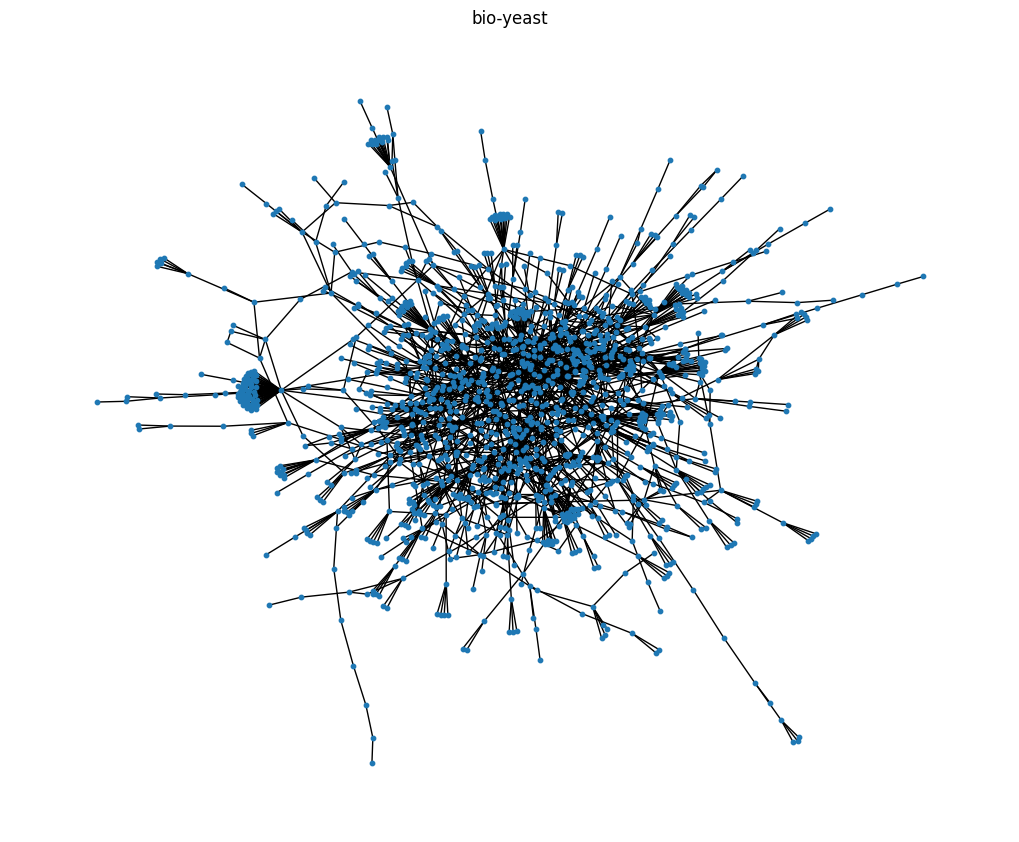

In [ ]:
file_path = base_path + 'data/bio-yeast.mtx' #Shared drive
G_real_bio_yeast = load_mtx_graph(file_path, graph_title="bio-yeast", show_graph=True )

##Density

What kind of network is it?
Dense or Sparse? \\

$|V| = n$ \\
$|E| = m$ \\

We can say that a network is dense when $ m \approx n^2 $ and is sparse when $ m \approx n $


$ D = \frac{m}{\frac{n(n-1)}{2}} = \frac{2m}{n(n-1)} $

When D is close to 0, the graph is sparse, and when the density is near 1, the graph is dense.

**Important Reminder** : $\frac{n(n-1)}{2}$ is the maximun of possible edges in an undirected graph.









In [ ]:
density = nx.density(G_real_bio_yeast)
print(f"Density: {density}")

Density: 0.0018340107310340413


Since we have a low density we have a sparse graph.


## Degree Distribution

The Degree distrubution p(k) is the probability that a randomly selected node in the network has degree k. Since p(k) is a probability the $\sum_{i=1}^{∞}{p(k)} = 1$
i.e if we select a node randomly, witch is the prob that thet node has degree 5? is p(5).


In [ ]:
degree_hist = nx.degree_histogram(G_real_bio_yeast) # the position is the degree, and the number in that postion is the #nodes with that degree
# i.e [1, 10, 20, 30, 40] 1 nodes with deg 0, 10 nodes with deg 1, 20 nodes with deg 2, .. and so on..
# Complexity: O(n+m)

In [ ]:
normalised_degree_hist = [nk/sum(degree_hist) for nk in degree_hist]

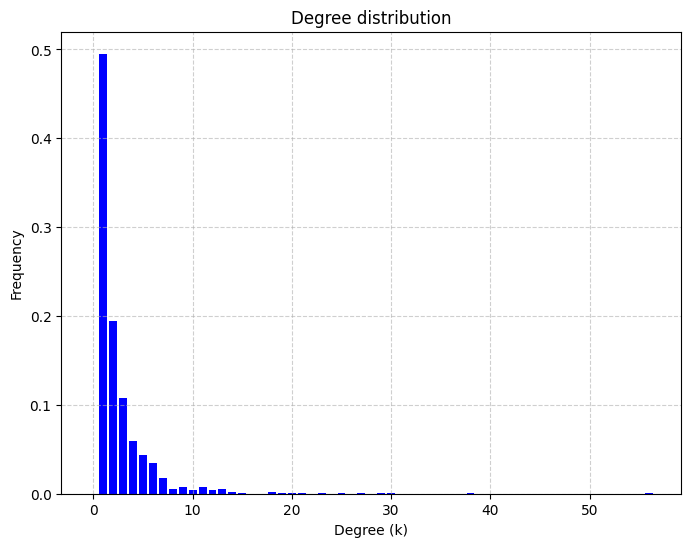

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(normalised_degree_hist)), normalised_degree_hist, color='blue')
plt.xlabel('Degree (k)')
plt.ylabel('Frequency')
plt.title('Degree distribution')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

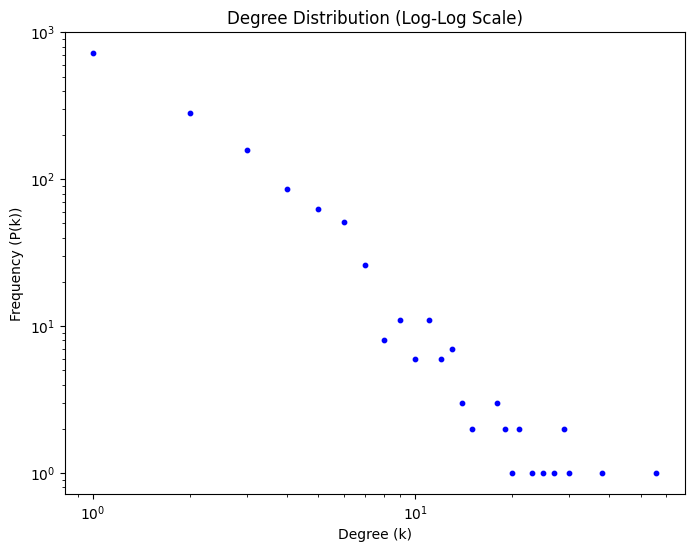

In [ ]:
plot_degree_distribution(G_real_bio_yeast, graph_title="Degree Distribution", log_log=True)

To run the powerlaw function first we need to install the library power law

In [ ]:
!pip install powerlaw


In [ ]:
import powerlaw

#Example with node degrees
degrees = [d for n, d in G_real_bio_yeast.degree()]  #List of degree

#Fit the distribution to a power law
fit = powerlaw.Fit(degrees)

#Show the exponent of the power law
print(f"Exponent (alpha): {fit.power_law.alpha}")
print(f"Min value: {fit.power_law.xmin}")

#Compare the distribution to a Power Law
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"R: {R}, p-value: {p}")


Calculating best minimal value for power law fit
Exponent (alpha): 3.5097267779775976
Min value: 5.0
R: 36.933697289616234, p-value: 5.2082103130520305e-05


We can observe that the degree distribution follow a power low and since: A scale-free network is a network whose degree distribution follows a power law. This is a scale-free network.

## Clustering Coefficient

### Local Clustering Coefficient

The clustering coefficient measures how well the neighbors of a given node are connected to each other, providing insight into the local density of connections.
For a node $i$ with degree $k_i$ (i.e., having $k_i$ neighbours), the local clustering coefficient is defined as:

$C_i = \frac{2L_i}{k_i(k_i-1)}$


where:
- $L_i$: The number of edges actually existing between the neighbors of node i.
- $\frac{k_i(k_i-1)}{2}$ : The maximum possible edges between the neighbors of node i (potential triangles).

Two possible interpretation:
- $C_i$ is the probability that node i is involved into a triangle.
- $C_i$ is the probability that the neighbours of node i are linked.

### Average Clustering Coefficient (Global)

$ <C> =  \frac{1}{N} \sum_{i = 1}^{N}{C_i}$



In [ ]:
nx.average_clustering(G_real_bio_yeast) # Compexity: O(n<k>^2) (globally)
# you compute at max ki(ki-1)/2 (locally) number of triangles for each node i. So we have n nodes, and the complexity is n*<k>(<k>-1)/2 = O(n<k>^2)

0.07083049680177282

In [ ]:
triangles = nx.triangles(G_real_bio_yeast) # {}

#Let's say 'triangles' is your dictionary
triangles_sorted = dict(sorted(triangles.items()))

In [ ]:
print(triangles_sorted) # key = Node ID value = #triangles

{1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 3, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 3, 21: 0, 22: 3, 23: 0, 24: 0, 25: 10, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 1, 32: 13, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 3, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 3, 65: 0, 66: 0, 67: 2, 68: 0, 69: 0, 70: 0, 71: 0, 72: 3, 73: 0, 74: 0, 75: 1, 76: 0, 77: 0, 78: 0, 79: 0, 80: 3, 81: 4, 82: 2, 83: 0, 84: 0, 85: 3, 86: 0, 87: 0, 88: 0, 89: 1, 90: 0, 91: 0, 92: 1, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 2, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 1, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 3, 123: 0, 124: 2, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 3, 135: 0, 136: 3, 137: 0, 138: 0, 1

## Calculate Average Path Lenght
The avarage path lenght is defined as:
the mean of the shortest path lengths between all pairs of nodes in the network.
$
    \langle d \rangle= \frac{1}{n(n - 1)} \sum_{u \neq v} d(u, v)
$

In [ ]:
nx.average_shortest_path_length(G_real_bio_yeast, weight=False) # O(n+m) (Adj List)

6.812366015065626

## Community

### Edge Betweenness Centrality

Edge Betweenness Centrality measures the number of shortest paths passing through a given edge.

$C_B(e) = \sum_{s \neq t}{\frac{\sigma{(s,t|e)}}{\sigma{(s,t)}}}$

Where:

- $\sigma{(s,t)}$: Total number of shortest paths between nodes s and t.
- $\sigma{(s,t|e)}$: The number of shortest paths between s and t that pass through edge e.
- Summed over all node pairs s,t.

In [ ]:
#Calculate Edge Betweenness Centrality
edge_betweenness = nx.edge_betweenness_centrality(G_real_bio_yeast) #O(n*m)

#Display top 10 edges with highest betweenness centrality
sorted_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
print("Top 10 edges with highest betweenness centrality:")
for edge, centrality in sorted_edges[:10]:
    print(f"Edge {edge}: {centrality}")

Top 10 edges with highest betweenness centrality:
Edge (147, 253): 0.056450245091909976
Edge (819, 844): 0.0492997827631979
Edge (819, 253): 0.04761311430289427
Edge (819, 465): 0.030171640455740934
Edge (819, 241): 0.02994360616137848
Edge (465, 1164): 0.029276234169812294
Edge (98, 266): 0.028080361079583945
Edge (147, 535): 0.02729824554487736
Edge (1, 595): 0.025919344700903662
Edge (819, 90): 0.02565120213940038


### Community Detection

### **Introduction**
This chapter introduces the concept of **community detection** in complex networks, which aims to identify groups of nodes that are **densely connected** internally and **sparsely connected** externally. Communities are fundamental to understanding the structure and functionality of real-world networks, such as social, biological, and technological systems.

### **Hypotheses**
1. **H1 - Fundamental Hypothesis:**
   - **Hypothesis:** Community structure is encoded in the network's **wiring diagram**.
   - **Proof:** Networks like Zachary's Karate Club reveal communities based on connection patterns. After a split in the group, algorithms accurately reconstructed the two factions, supporting the idea that structure alone encodes communities.

2. **H2 - Connectedness and Density Hypothesis:**
   - **Hypothesis:** A community is a **connected subgraph** with **dense internal links** and sparse external links.
   - **Proof:** Biological networks, such as metabolic pathways, group molecules into functional modules with higher internal connectivity. These patterns support the definition of communities based on connectedness and density.

3. **H3 - Random Hypothesis:**
   - **Hypothesis:** **Random networks** lack inherent community structure, and any observed clusters arise **by chance**.
   - **Proof:** Comparing link densities in observed networks to randomized versions shows deviations that cannot be explained by randomness alone, proving the existence of meaningful communities.

4. **H4 - Maximal Modularity Hypothesis:**
   - **Hypothesis:** The **optimal partition** of a network corresponds to the one that **maximizes modularity (M)**.
   - **Proof:** Algorithms like **Greedy** and **Louvain** optimize modularity to uncover partitions that outperform random structures, validating this hypothesis with strong empirical results.

---

### **Hierarchical Clustering and Girvan-Newman Algorithm**
- **Hierarchical Clustering**:
  - Communities are detected iteratively using **agglomerative (bottom-up)** or **divisive (top-down)** methods.
  - Produces a **dendrogram** representing hierarchical partitions.
  - However, it does **not specify** where to **cut the dendrogram** to identify the best communities.

- **Girvan-Newman Algorithm:**
  - **Divisive method** based on **edge betweenness centrality**.
  - Steps:
    1. Compute **betweenness centrality** for all edges.
    2. Iteratively **remove edges** with **highest betweenness**.
    3. Observe how the graph splits into **communities**.
  - Produces a **hierarchical partitioning** but requires **additional criteria** to determine the **optimal cut**.

---

### **Modularity (M)**
- **Definition:** Measures the **quality** of a given partition by comparing the **density of links** within communities against a **random network model**.
- Formula:
  
  $
  M = \sum_{c=1}^{n_c}\left[ \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2 \right]
  $

  Where:
  - $L_c$: Number of edges within community $c$.
  - $L$: Total number of edges.
  - $k_c$: Sum of node degrees within $c$.

- **Key Properties:**
  1. $M > 0$: Strong community structure.
  2. $M = 0$: No better than random.
  3. $M < 0$: Worse than random.
  4. Higher $M$ implies **better partitions**.

---

### **Optimizing Modularity**
- **Greedy Algorithm:**
  - Iteratively **merge communities** to maximize modularity.
  - Complexity: **O(N^2)** for sparse graphs.
- **Louvain Algorithm:**
  - Faster method with complexity **O(L)**, scalable to **millions of nodes**.

---

### **Challenges in Community Detection**
1. **Resolution Limit:**
   - Small communities are sometimes **merged into larger ones**, hiding finer structures.
2. **Modularity Plateau:**
   - Many partitions can yield **similar modularity scores**, making it hard to identify the **optimal partition**.
3. **Random Effects:**
   - Even random networks may exhibit **high modularity**, conflicting with the **random hypothesis**.

---

### **Conclusion**
Community detection is essential for analyzing network structures, identifying clusters, and interpreting relationships. The **Girvan-Newman algorithm** and **modularity optimization** provide effective tools, but careful interpretation is needed due to challenges like **resolution limits** and **ambiguous optima**. Combining algorithms and modularity measures often yields the **best results**.



Number of communities: 2
New best modularity: 0.09052352963498612
Number of communities: 3
New best modularity: 0.13915459545724784
Number of communities: 4
New best modularity: 0.16601914141392848
Number of communities: 5
New best modularity: 0.1897532719284562
Number of communities: 6
New best modularity: 0.2172442172037661
Number of communities: 7
New best modularity: 0.23223142042172473
Number of communities: 8
New best modularity: 0.2950778242519048
Number of communities: 9
New best modularity: 0.35250285661279507
Number of communities: 10
New best modularity: 0.568343407021997
Number of communities: 11
New best modularity: 0.6651045773267164
Number of communities: 12
New best modularity: 0.7036223378687771
Number of communities: 13
New best modularity: 0.7203456448777033
Number of communities: 14
New best modularity: 0.7548924764619321
Number of communities: 15
New best modularity: 0.7662251126833608
Number of communities: 16
New best modularity: 0.775787913892625
Number of commu

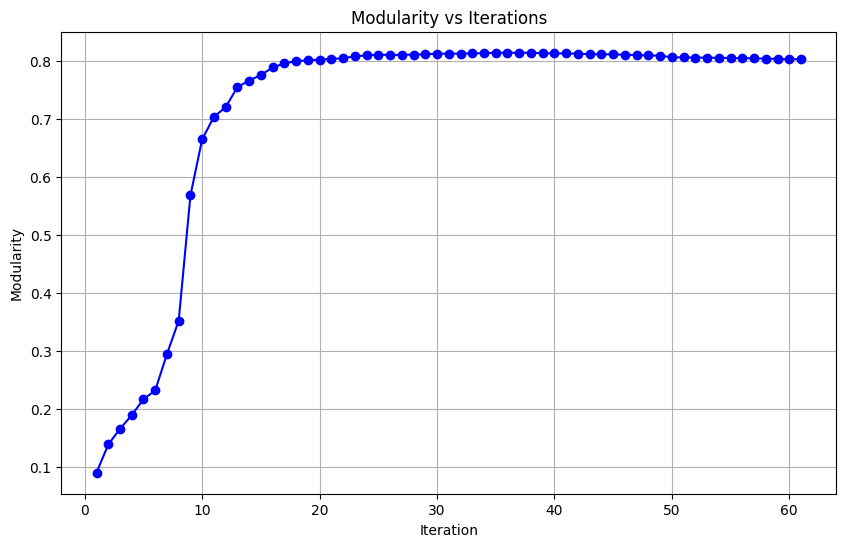

In [ ]:
best_partition, modularities, partitions = communities_detection(G_real_bio_yeast)
#best_partition, modularities, partitions = load_communities('/content/drive/MyDrive/CSN_PROJECT/metrics/results/bio_yeast_communities.json')
plot_modularities(modularities)

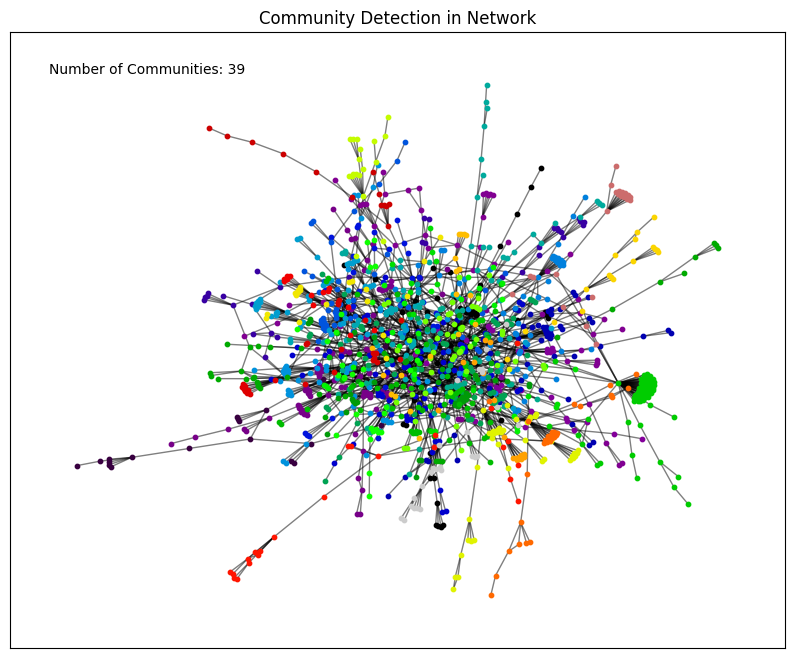

In [ ]:
plot_communities(G_real_bio_yeast, best_partition)

In [ ]:
base_path = '/content/drive/MyDrive/CSN_PROJECT/'
save_community_metrics(G_real_bio_yeast, best_partition, base_path, 'bio_yeast')

Saved communities and metrics for bio_yeast


## Degree Correlation

## 1. Introduction: Social vs. Biological Networks
- **Social Networks:**  
  In social networks, hubs tend to connect with other hubs, forming **assortative patterns**.  
- **Biological Networks:**  
  In biological systems, such as protein interaction networks, hubs **avoid connecting with other hubs** and instead link to low-degree nodes, forming a **hub-and-spoke structure**.



## 2. Assortativity and Disassortativity
### Definition:
**Degree correlation** measures whether nodes with similar or different degrees tend to connect.  

### Types of Networks:
1. **Assortative Networks:** Hubs connect to other hubs.  
2. **Disassortative Networks:** Hubs connect to low-degree nodes.  
3. **Neutral Networks:** Connections occur randomly without degree preference.  

---

## 3. Degree Correlation Matrix ($e_{ij}$)

### Definition:
A matrix $e_{ij}$ represents the probability that a node with degree $i$ connects to a node with degree $j$.  

### Equation:
$$
\sum_{i, j} e_{ij} = 1
$$

$$
e_{ij} = q_i q_j
$$
where:
$$
q_k = \frac{k \cdot p_k}{<k>}
$$

### Observations:
- **Assortative Networks:** High values along the **main diagonal** (hubs connect to hubs).  
- **Disassortative Networks:** High values along the **secondary diagonal** (hubs connect to low-degree nodes).  
- **Neutral Networks:** No clear patterns, indicating random connections.  

---

## 4. Degree Correlation Function ($k_{nn}(k)$)

### Definition:
Measures the **average degree of neighbors** of nodes with degree $k$.  

### Formula:
$$
k_{nn}(k) = \sum_{k'} k' P(k' | k)
$$

where:
- $P(k' | k)$ is the conditional probability that a node with degree $k$ connects to a node with degree $k'$.

### Behavior:
- **Assortative Networks:** $k_{nn}(k)$ **increases** with $k$.  
- **Disassortative Networks:** $k_{nn}(k)$ **decreases** with $k$.  
- **Neutral Networks:** $k_{nn}(k)$ is **constant**.  

### Examples:
- **Scientific collaboration networks:** Assortative.  
- **Metabolic networks:** Disassortative.  
- **Power grids:** Neutral.  


## 5. Conclusion

Degree correlations shape the structure and behavior of complex networks:  
- **Social Networks:** Tend to be **assortative**, where hubs connect to other hubs.  
- **Biological Networks:** Tend to be **disassortative**, showing a **hub-and-spoke** model.  
- **Neutral Networks:** Exhibit random connections without correlations.  

These principles provide insights into real-world systems, from **social dynamics** to **biological interactions**, helping to model and analyze their structural properties.


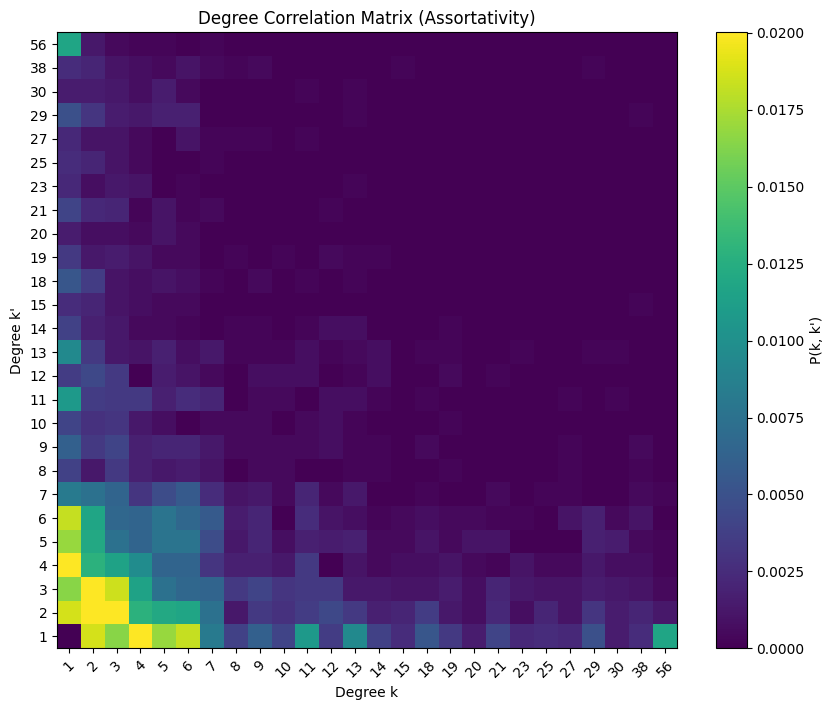

In [ ]:
#Calculate the degree correlation matrix
joint_degree_matrix = nx.degree_mixing_matrix(G_real_bio_yeast, normalized=True)

#List of degrees actually present in the network
unique_degrees = get_unique_degrees(G_real_bio_yeast)

#Draw heatmap with improved scale to highlight details
plt.figure(figsize=(10, 8))
plt.imshow(joint_degree_matrix, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label="P(k, k')")
plt.xlabel("Degree k")
plt.ylabel("Degree k'")
plt.title('Degree Correlation Matrix (Assortativity)')
plt.xticks(np.arange(len(unique_degrees)), unique_degrees, rotation=45)
plt.yticks(np.arange(len(unique_degrees)), unique_degrees)
plt.show()

## **Disassortative Networks**  
In disassortative networks, hubs avoid connecting with each other and instead link to small-degree nodes. Consequently, the network exhibits a **hub-and-spoke** structure, making it disassortative.

---

### **Observations from the Heatmap**  

1. **Concentration in Low Degrees (Bottom-Left Region):**  
   - Most connections are concentrated among low-degree nodes.  
   - This pattern is often typical in **assortative networks**, where nodes with similar degrees tend to connect.  

2. **Low Density of Connections Between High and Low Degrees:**  
   - High-degree nodes do not show significant connections with low-degree nodes (no strong presence in the **top-left** and **bottom-right** regions).  
   - This behavior aligns with **slightly disassortative networks**, such as **scale-free** structures.  

3. **Sparse Distribution in High Degrees:**  
   - Few non-zero values in the high-degree region suggest that high-degree nodes have relatively **few direct connections** with other high-degree nodes.  
   - This reinforces the **disassortative behavior** observed in the network.

---

### **Conclusion:**
The heatmap supports the hypothesis that the network exhibits a **slightly** **disassortative structure**, characterized by **hubs connecting primarily to low-degree nodes** rather than forming links with other hubs.


In [ ]:
#Compute k_nn(k) for the network
knn = nx.average_degree_connectivity(G_real_bio_yeast)
k = np.array(sorted(knn.keys()))  #Sort the degrees in ascending order
knnk = np.array([knn[i] for i in k])  #Align k_nn(k) to ordered degrees

#Print results sorted by grade
for degree in k:
    print(f"Degree: {degree}, k_nn(k): {knn[degree]}")


Degree: 1, k_nn(k): 12.555401662049862
Degree: 2, k_nn(k): 7.904593639575972
Degree: 3, k_nn(k): 6.961783439490445
Degree: 4, k_nn(k): 5.968023255813954
Degree: 5, k_nn(k): 6.450793650793651
Degree: 6, k_nn(k): 6.0816993464052285
Degree: 7, k_nn(k): 5.6208791208791204
Degree: 8, k_nn(k): 5.15625
Degree: 9, k_nn(k): 5.3232323232323235
Degree: 10, k_nn(k): 4.116666666666666
Degree: 11, k_nn(k): 4.24793388429752
Degree: 12, k_nn(k): 4.986111111111111
Degree: 13, k_nn(k): 4.846153846153846
Degree: 14, k_nn(k): 4.523809523809524
Degree: 15, k_nn(k): 3.6666666666666665
Degree: 18, k_nn(k): 2.962962962962963
Degree: 19, k_nn(k): 3.8947368421052633
Degree: 20, k_nn(k): 3.05
Degree: 21, k_nn(k): 2.7142857142857144
Degree: 23, k_nn(k): 2.8260869565217392
Degree: 25, k_nn(k): 2.12
Degree: 27, k_nn(k): 3.5555555555555554
Degree: 29, k_nn(k): 3.603448275862069
Degree: 30, k_nn(k): 3.7
Degree: 38, k_nn(k): 4.421052631578948
Degree: 56, k_nn(k): 1.3928571428571428


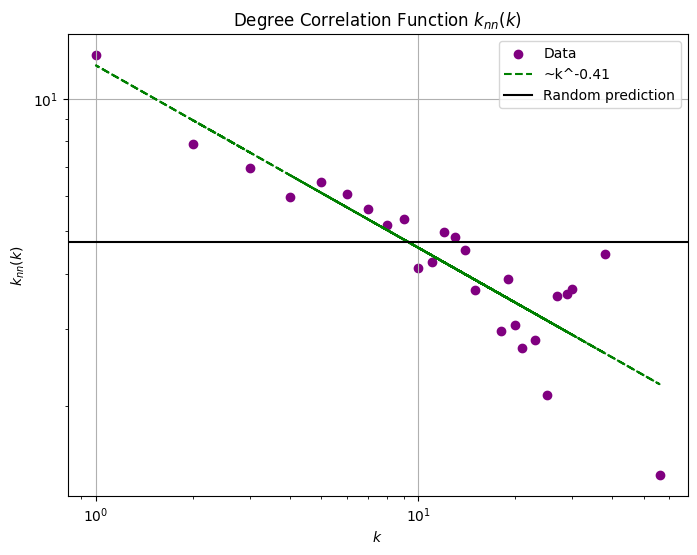

In [ ]:
#Calculate k_nn(k) for the graph
knn = nx.average_degree_connectivity(G_real_bio_yeast)
k = np.array(list(knn.keys()))
knnk = np.array(list(knn.values()))

#Plot of k_nn(k) in log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(k, knnk, color='purple', label="Data")
plt.xscale('log')
plt.yscale('log')

#Linear regression on log-log scale to estimate behavior
coeffs = np.polyfit(np.log10(k), np.log10(knnk), 1)
fit_line = 10**(np.poly1d(coeffs)(np.log10(k)))

#Draw the random prediction (black line) and the fit (dashed green line)
plt.plot(k, fit_line, 'g--', label=f"~k^{coeffs[0]:.2f}")
plt.axhline(y=np.mean(knnk), color='black', linestyle='-', label="Random prediction")

plt.xlabel('$k$')
plt.ylabel('$k_{nn}(k)$')
plt.title('Degree Correlation Function $k_{nn}(k)$')
plt.legend()
plt.grid(True)
plt.show()

### Power-Law Estimation for the Degree Correlation Function

### **Description**
The function $ k_{nn}(k) $ measures the average degree of the neighbors of a node with degree $ k $. It is useful for analyzing the structure of a network.

### **Methodology**
The relationship between $ k_{nn}(k) $ and $ k $ is often described by a power-law:
$
 k_{nn}(k) \propto k^\mu
$
where $ \mu $ represents the scaling exponent.

To estimate $ \mu $, a linear regression is applied after taking the logarithm of the data:
$
\log_{10}(k_{nn}(k)) = \mu \cdot \log_{10}(k) + C
$
This transformation linearizes the relationship, making $ \mu $ the slope of the line in the log-log scale.

### **Results**
An exponent of approximately $ -0.41 $ suggests a **disassortative** behavior, which is typical of **biological networks**. In this context, high-degree nodes tend to connect to low-degree nodes.

### **Conclusion**
The negative exponent indicates a scalable and disassortative structure, where central nodes (hubs) are primarily connected to peripheral nodes.



##  $$ k_{nn}(k) \text{ vs } k $$


### **Low degree nodes $ k = 1, 2, 3, ...$ :**

- $k_{\text{nn}}(1) = 12.55 $: Nodes with a single connection are connected to nodes with a high average degree (hubs).
-  $k_{\text{nn}}(2)$ = 7.90 $ : Nodes with two connections are also connected to more central nodes.



### **High degree nodes $k = 20, 25, 38, ...$ :**

-  $k_{\text{nn}}(20) = 3.05$ : High-degree nodes tend to connect to nodes with much lower degrees.
-  $k_{\text{nn}}(56) = 1.39$ : The most connected nodes (super-hubs) are mainly connected to peripheral nodes.

This is **disassortative** behavior.






In [ ]:
r = nx.degree_pearson_correlation_coefficient(G_real_bio_yeast)
print(f"R: {r}")

R: -0.20954054116464876


In [ ]:
ass = nx.degree_assortativity_coefficient(G_real_bio_yeast)
print(f"Assortativity: {ass}")

Assortativity: -0.20954054116464865


For $R<0$ we have dissassortative network, so:

The R value, confirm that we have a dissassortative network.


# Phase 2: Comparison with Network Models 📊

##Phase 2 function

In [ ]:
def evaluate_graph_model(G_real, G_model):
    """
    Compare a real-world graph with a theoretical model by calculating structural metrics.

    Parameters:
      - G_real: Real-world graph (NetworkX Graph).
      - G_model: Generated theoretical graph (NetworkX Graph).

    Output:
      - Prints metrics, relative/absolute differences, and evaluates the model.
    """
    print("===== Theoretical Model Evaluation =====\n")

    #Average Degree
    real_degrees = [d for _, d in G_real.degree()]
    model_degrees = [d for _, d in G_model.degree()]
    real_avg_degree = np.mean(real_degrees)
    model_avg_degree = np.mean(model_degrees)
    degree_diff = abs(real_avg_degree - model_avg_degree) / real_avg_degree
    print("Average Degree:")
    print(f"  Real average degree: {real_avg_degree:.2f}")
    print(f"  Model average degree: {model_avg_degree:.2f}")
    print(f"  Relative difference: {degree_diff:.2%}")

    #Clustering Coefficient
    real_clustering = nx.average_clustering(G_real)
    model_clustering = nx.average_clustering(G_model)
    clustering_diff = abs(real_clustering - model_clustering) / (real_clustering + 1e-9)
    print("\nClustering Coefficient:")
    print(f"  Real average clustering: {real_clustering:.4f}")
    print(f"  Model average clustering: {model_clustering:.4f}")
    print(f"  Relative difference: {clustering_diff:.2%}")

    #Number of Triangles
    real_triangles = sum(nx.triangles(G_real).values()) // 3
    model_triangles = sum(nx.triangles(G_model).values()) // 3
    triangles_diff = abs(real_triangles - model_triangles) / (real_triangles + 1e-9)
    print("\nNumber of Triangles:")
    print(f"  Real triangles: {real_triangles}")
    print(f"  Model triangles: {model_triangles}")
    print(f"  Relative difference: {triangles_diff:.2%}")

    #Average Path Length or Connected Components
    if nx.is_connected(G_real) and nx.is_connected(G_model):
        real_path_length = nx.average_shortest_path_length(G_real)
        model_path_length = nx.average_shortest_path_length(G_model)
        path_length_diff = abs(real_path_length - model_path_length) / real_path_length
        print("\nAverage Path Length:")
        print(f"  Real average path length: {real_path_length:.2f}")
        print(f"  Model average path length: {model_path_length:.2f}")
        print(f"  Relative difference: {path_length_diff:.2%}")
    else:
        real_components = nx.number_connected_components(G_real)
        model_components = nx.number_connected_components(G_model)
        print("\nConnected Components:")
        print(f"  Real number of components: {real_components}")
        print(f"  Model number of components: {model_components}")
        path_length_diff = None

    #Assortativity Coefficient
    real_assortativity = nx.degree_assortativity_coefficient(G_real)
    model_assortativity = nx.degree_assortativity_coefficient(G_model)
    assortativity_diff = abs(real_assortativity - model_assortativity)
    print("\nAssortativity:")
    print(f"  Real assortativity: {real_assortativity:.4f}")
    print(f"  Model assortativity: {model_assortativity:.4f}")
    print(f"  Absolute difference: {assortativity_diff:.4f}")

    #Calculate Edge Betweenness Centrality
    real_edge_betweenness = nx.edge_betweenness_centrality(G_real) # O(n*m)
    model_edge_betweenness = nx.edge_betweenness_centrality(G_model) # O(n*m)

    #Compare Edge Betweenness Centrality
    real_sorted_edges = sorted(real_edge_betweenness.items(), key=lambda x: x[1], reverse=True)
    model_sorted_edges = sorted(model_edge_betweenness.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 10 edges with highest betweenness centrality in Real Graph:")
    for edge, centrality in real_sorted_edges[:10]:
        print(f"Edge {edge}: {centrality}")

    print("\nTop 10 edges with highest betweenness centrality in Model Graph:")
    for edge, centrality in model_sorted_edges[:10]:
        print(f"Edge {edge}: {centrality}")

    #Plot degree distributions
    plt.figure(figsize=(10, 6))
    plt.hist(real_degrees, bins=30, alpha=0.5, label="Real", color="orange", density=True)
    plt.hist(model_degrees, bins=30, alpha=0.5, label="Theoretical", color="blue", density=True)
    plt.title("Degree Distribution Comparison")
    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"- Average degree: relative difference {degree_diff:.2%}")
    print(f"- Clustering: relative difference {clustering_diff:.2%}")
    print(f"- Triangles: relative difference {triangles_diff:.2%}")
    if path_length_diff is not None:
        print(f"- Average path length: relative difference {path_length_diff:.2%}")
    else:
        print(f"- Connected components evaluated.")
    print(f"- Assortativity: absolute difference {assortativity_diff:.4f}")


def compute_m(G_real):
    N = G_real.number_of_nodes()
    E = G_real.number_of_edges()

    #Calculate the average degree
    average_degree = 2 * E / N


    #Calculate the value of m
    m = int(average_degree / 2)
    return m

## Erdos-Renyi Model

### Introduction

The Erdős–Rényi model is a model for generating random graphs in which all graphs with a fixed set of vertices and a fixed set of edges are equally probable. There are two closely related variants of the model: binomial and uniform random graph models.

#### Definition

**Binomial Random Graph Model (G(n, p)):**  
   Binomial random graph model $G(n,p)$ is a model in which each edge is included in a random graph independently of other edges with probability $p$. The graph is represented as:
   - $G(n, p)$
---

### Model Dynamics

The dynamics of the Erdős–Rényi model $G(n, p)$ are as follows:

1. **Node and Edge Initialization:**  
   - Start with $n$ nodes.
   - For each pair of nodes, add an edge with probability $p$. This process is independent for all pairs of nodes.

2. **Edge Probability:**  
   The probability $p$ determines the graph's density:
   - $p \approx 0$: The graph is sparse.
   - $p \approx 1$: The graph is nearly complete.

3. **Randomness and Independence:**  
   All edges are formed independently of each other, ensuring a truly random graph structure.

---

### Properties and Analysis

1. **Degree Distribution:**  
   - The degree $k$ of a node follows a binomial distribution:
$$
P(\text{degree} = k) = \binom{n-1}{k} p^k (1-p)^{n-1-k}
$$

   - For large $n$ and small $p$, this approximates a Poisson distribution.

2. **Clustering Coefficient:**  
   - The clustering coefficient tends to be small due to the lack of triadic closures.

3. **Path Length:**  
   - The average path length decreases with increasing $p$, leading to a "small-world" effect for certain probabilities.

4. **Thresholds:**  
   - **Connectivity Threshold:** $p_c \approx \frac{\ln(n)}{n}$. If $p > p_c$, the graph is almost surely connected.
   - **Giant Component Threshold:** If $p > \frac{1}{n}$, a giant connected component emerges.

---

### Evaluation

Given a real network (e.g., **bio-yeast graph**), the Erdős–Rényi model can be evaluated as follows:

1. **Compute Maximum Number of Edges:**  
   $$
   \text{max_edges} = \frac{n(n-1)}{2}
   $$

2. **Determine Edge Probability:**  
   $$
   p = \frac{\text{actual_edges}}{\text{max_edges}}
   $$

3. **Generate Erdős–Rényi Graph:**  
   Use $nx.erdos\_renyi\_graph(n, p)$ to create a graph with the same number of nodes and edge probability.

4. **Compare Metrics:**  
   Use functions like `evaluate_graph_model` to compare the generated graph's degree distribution, clustering coefficient, and path lengths to the real graph.

---

### Conclusion

The Erdős–Rényi model features:

1. **Random Edge Distribution:** Each node has a probability of connecting to any other node, creating a random edge distribution.
2. **Small Average Path Length:** With sufficient connection probability, the network exhibits small average path lengths, typical of small-world behavior.
3. **High Connectivity:** The network remains connected even with low edge probability, ensuring overall structure.
4. **No Clustering:** Unlike the Watts-Strogatz model, there is no significant clustering in the network.
5. **Simplicity and Flexibility:** The model is simple to compute and commonly used to model random graphs across various fields.


Max number of edges: 1062153.0
Actual number of edges: 1948
Probability to have edges: 0.0018340107310340413
===== Theoretical Model Evaluation =====

Average Degree:
  Real average degree: 2.67
  Model average degree: 2.65
  Relative difference: 0.67%

Clustering Coefficient:
  Real average clustering: 0.0708
  Model average clustering: 0.0024
  Relative difference: 96.65%

Number of Triangles:
  Real triangles: 206
  Model triangles: 7
  Relative difference: 96.60%

Connected Components:
  Real number of components: 1
  Model number of components: 130

Assortativity:
  Real assortativity: -0.2095
  Model assortativity: 0.0042
  Absolute difference: 0.2138

Top 10 edges with highest betweenness centrality in Real Graph:
Edge (147, 253): 0.056450245091909976
Edge (819, 844): 0.0492997827631979
Edge (819, 253): 0.04761311430289427
Edge (819, 465): 0.030171640455740934
Edge (819, 241): 0.02994360616137848
Edge (465, 1164): 0.029276234169812294
Edge (98, 266): 0.028080361079583945
Edge (1

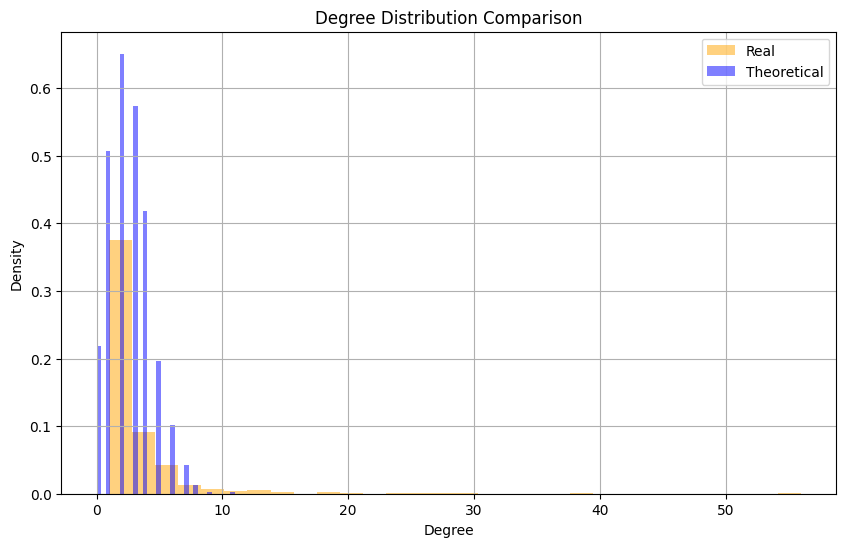

- Average degree: relative difference 0.67%
- Clustering: relative difference 96.65%
- Triangles: relative difference 96.60%
- Connected components evaluated.
- Assortativity: absolute difference 0.2138


In [ ]:
max_number_of_edges = (G_real_bio_yeast.number_of_nodes() * (G_real_bio_yeast.number_of_nodes() - 1))/2
act_max_number_of_edges = G_real_bio_yeast.number_of_edges()
print(f"Max number of edges: {max_number_of_edges}")
print(f"Actual number of edges: {act_max_number_of_edges}")

probability_to_have_edges = act_max_number_of_edges / max_number_of_edges
print(f"Probability to have edges: {probability_to_have_edges}")

G_erdos_renyi_bio_yeast = nx.erdos_renyi_graph(G_real_bio_yeast.number_of_nodes(), probability_to_have_edges, seed=SEED)
evaluate_graph_model(G_real_bio_yeast, G_erdos_renyi_bio_yeast)

Number of communities: 131
New best modularity: 0.03061568148281686
Number of communities: 132
New best modularity: 0.05443703303086747
Number of communities: 133
New best modularity: 0.0729957467833798
Number of communities: 134
New best modularity: 0.0899174061387871
Number of communities: 135
New best modularity: 0.11395201944327596
Number of communities: 136
New best modularity: 0.1554249544298219
Number of communities: 137
New best modularity: 0.1710783940601861
Number of communities: 138
New best modularity: 0.19706574791846126
Number of communities: 139
New best modularity: 0.24136276532526765
Number of communities: 140
New best modularity: 0.3013861346473569
Number of communities: 141
New best modularity: 0.37328859777390505
Number of communities: 142
New best modularity: 0.5113868691117658
Number of communities: 143
New best modularity: 0.613274976797602
Number of communities: 144
New best modularity: 0.6390266343502331
Number of communities: 145
New best modularity: 0.6520655

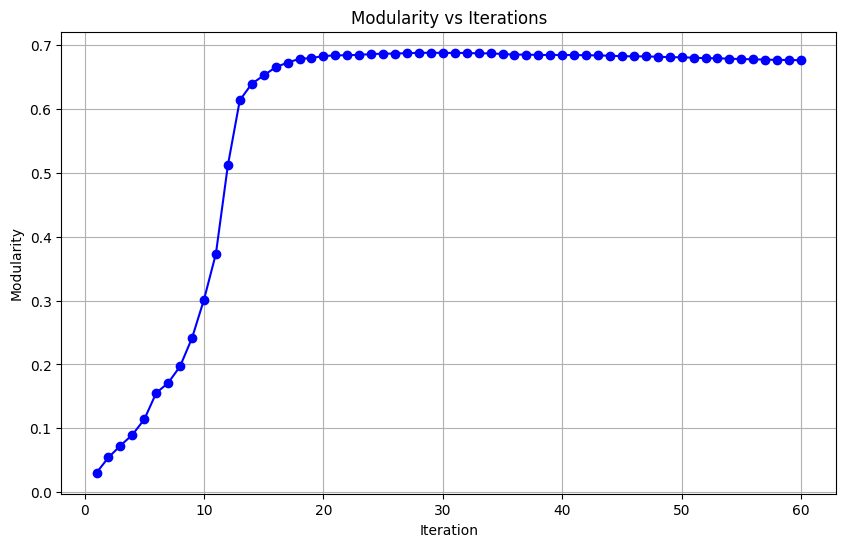

In [ ]:
random_best_partition, random_modularities, random_partitions = communities_detection(G_erdos_renyi_bio_yeast)
#random_best_partition, random_modularities, random_partitions = load_communities('/content/drive/MyDrive/CSN_PROJECT/metrics/results/bio_yeast_erdos_renyi_communities.json')
plot_modularities(random_modularities)

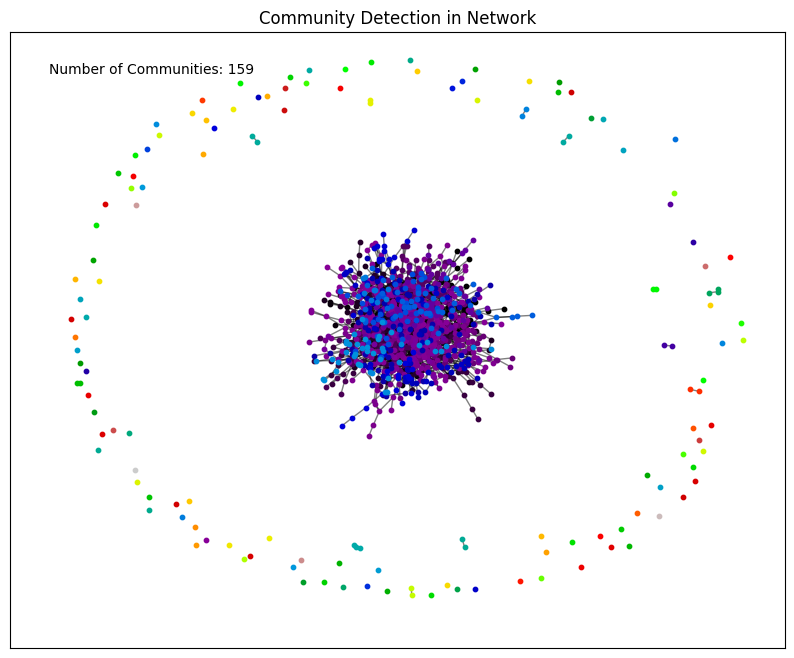

In [ ]:
plot_communities(G_erdos_renyi_bio_yeast, random_best_partition)

In [ ]:
save_community_metrics(G_erdos_renyi_bio_yeast, random_best_partition, base_path, 'bio_yeast_erdos_renyi')

Saved communities and metrics for bio_yeast_erdos_renyi


## Watts-Strogatz Model

The Watts-Strogatz model is a random  model that produces graphs with small-world properties, including short average path lengths and high clustering.



---

###Model Dynamics
A Watts Strogatz model can be builded as follows:

1.  We start with a ring of nodes, each node connected to its immediate and next neightbors. Initially, the clustering coefficient is hight $(<C> = \frac {3}{4})$, meaning there is a strong tendency for nodes to form triangles.

2.  With probability $p$ each link is rewired to a randomly chosen node.

- For small $p$, the network maintain high clustering, but the random long-range links can drastically decrease the distance between the nodes.

- For $p = 1 $ all links been rewired, so the network turns into a random network.

---

### Conclusion

In conclusion, the Watts-Strogatz model combines the features of two types of networks:

- A **regular lattice**, which exhibits high clustering but does not show the small-world phenomenon.
- A **random network**, which exhibits low clustering but shows the small-world phenomenon.

The key to this combination is the rewiring parameter $p$. By varying $p$, the network transitions from a regular lattice to a random structure. For a specific range of $p$, the network exhibits both high clustering and short average path lengths, capturing the essence of small-world behavior.


Average global degree: 2

===== Theoretical Model Evaluation =====

Average Degree:
  Real average degree: 2.67
  Model average degree: 2.00
  Relative difference: 25.15%

Clustering Coefficient:
  Real average clustering: 0.0708
  Model average clustering: 0.0000
  Relative difference: 100.00%

Number of Triangles:
  Real triangles: 206
  Model triangles: 0
  Relative difference: 100.00%

Connected Components:
  Real number of components: 1
  Model number of components: 4

Assortativity:
  Real assortativity: -0.2095
  Model assortativity: -0.0316
  Absolute difference: 0.1779

Top 10 edges with highest betweenness centrality in Real Graph:
Edge (147, 253): 0.056450245091909976
Edge (819, 844): 0.0492997827631979
Edge (819, 253): 0.04761311430289427
Edge (819, 465): 0.030171640455740934
Edge (819, 241): 0.02994360616137848
Edge (465, 1164): 0.029276234169812294
Edge (98, 266): 0.028080361079583945
Edge (147, 535): 0.02729824554487736
Edge (1, 595): 0.025919344700903662
Edge (819, 90):

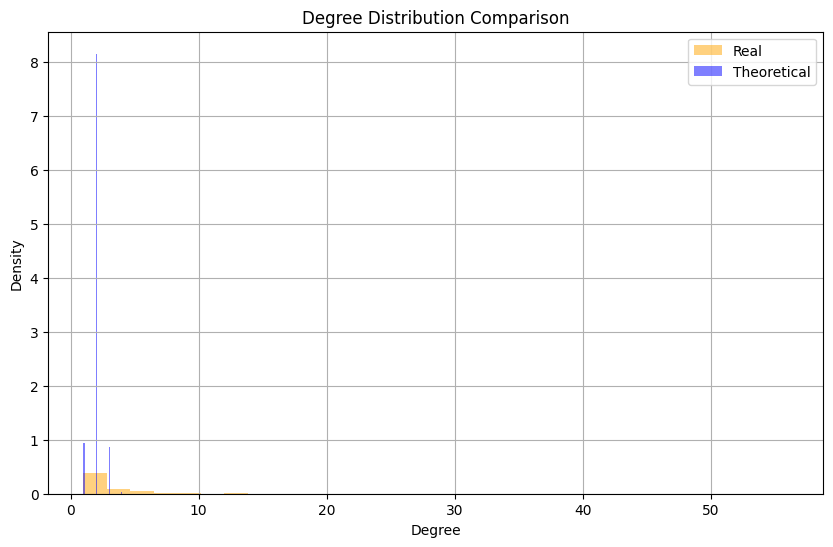

- Average degree: relative difference 25.15%
- Clustering: relative difference 100.00%
- Triangles: relative difference 100.00%
- Connected components evaluated.
- Assortativity: absolute difference 0.1779


In [ ]:
#Calculate the average global degree
k = 2 * G_real_bio_yeast.number_of_edges() // G_real_bio_yeast.number_of_nodes()
#print(f"Average global degree: {k}" + "\n")
#Set the probability of rewiring (p)
p = 0.1

#Create the Watts-Strogatz model based on the real bio yeast network
G_watts_strogatz_bio_yeast = nx.watts_strogatz_graph(G_real_bio_yeast.number_of_nodes(), k, p, seed=SEED)

#Evaluate the model by comparing it to the real network
evaluate_graph_model(G_real_bio_yeast, G_watts_strogatz_bio_yeast)


Number of communities: 5
New best modularity: 0.6727390716937534
Number of communities: 6
New best modularity: 0.7417810725931947
Number of communities: 7
New best modularity: 0.7883869046611006
Number of communities: 8
New best modularity: 0.8317823615415445
Number of communities: 9
New best modularity: 0.8488839777134244
Number of communities: 10
New best modularity: 0.8651543633253739
Number of communities: 11
New best modularity: 0.8812718627279416
Number of communities: 12
New best modularity: 0.8918379462630847
Number of communities: 13
New best modularity: 0.9028005931044085
Number of communities: 14
New best modularity: 0.90927638251471
Number of communities: 15
New best modularity: 0.9139786918961842
Number of communities: 16
New best modularity: 0.9177719163557198
Number of communities: 17
New best modularity: 0.9215004581882091
Number of communities: 18
New best modularity: 0.925100340395265
Number of communities: 19
New best modularity: 0.928140659075984
Number of communiti

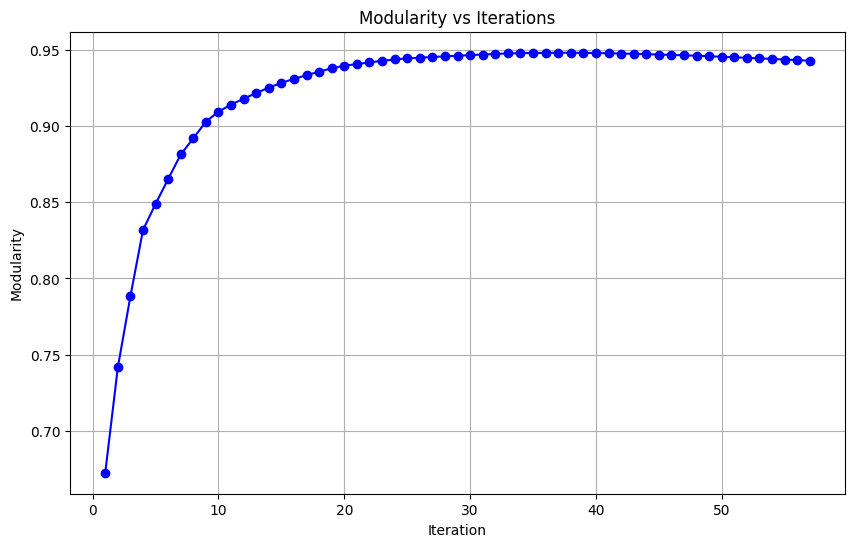

In [ ]:
watts_strogatz_best_partition, watts_strogatz_modularities, watts_strogatz_partitions = communities_detection(G_watts_strogatz_bio_yeast)
#watts_strogatz_best_partition, watts_strogatz_modularities, watts_strogatz_partitions = load_communities('/content/drive/MyDrive/CSN_PROJECT/metrics/results/bio_yeast_watts_strogatz_communities.json')
plot_modularities(watts_strogatz_modularities)

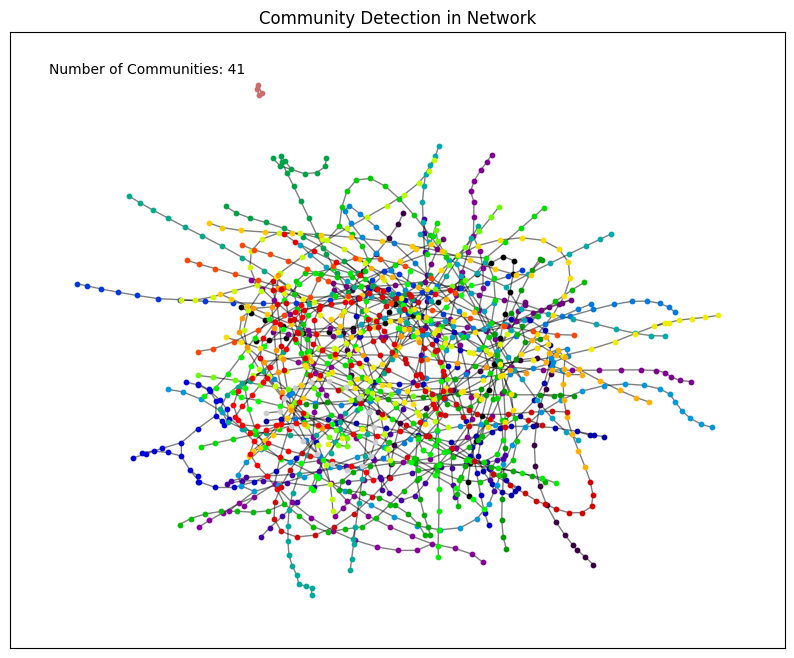

In [ ]:
plot_communities(G_watts_strogatz_bio_yeast, watts_strogatz_best_partition)

In [ ]:
save_community_metrics(G_watts_strogatz_bio_yeast, watts_strogatz_best_partition, base_path, 'bio_yeast_watts_strogatz')

Saved communities and metrics for bio_yeast_watts_strogatz


## Barabasi-Albert Model


Thanks to the study of real networks, two new fundamental properties have been discovered.

- **growth**: In real network the number of nodes continually grows thanks to the addition of new nodes.

- **preferential attachment**: Most of real network nodes prefer to link to the more connected nodes.

The discovery of these two properties led to the creation of a new theorical model, called the **Barabasi-Albert model**.


---


###Model Dynamics
The development follows the two previous properties:

- **growth**: At each timestep, a new node is introduced with $m$ links ($m \leq m_0$) that connect it to $m$ existing nodes in the network.

- **preferential attachment**: the probability that a link connect to node $i$ depends on the degree $K_i$ as

$$Π(K_i) = \frac{K_i}{\sum_j{K_j}} $$

This is a probabilistic mechanism, because a new node is free to connect to any node, but it is more likely that it connects to nodes with high-degree.

After $t$ timesteps, the **BA** model generates a network with $N = t + m_0$ nodes and $m_0 + m t$ links


- **$t$**: timestep

- **$m_0$**: nodes that we have at the beginning of our model

- **$m$**: nodes we are adding


---


###Impact of Missing Properties

- **absence of growth**: at early times each new link connects previously unconnected nodes and the evolution's network of this model is the same of **BA** model. But the probability is not stationary, so for large $t$ the network becomes a full connected network

- **absence of preferential attachment**: this absence lead to the absence of scale-free property and hubs. Indeed, as all nodes acquire links with equal probability, we lack a rich-get-richer process.

===== Theoretical Model Evaluation =====

Average Degree:
  Real average degree: 2.67
  Model average degree: 2.00
  Relative difference: 25.21%

Clustering Coefficient:
  Real average clustering: 0.0708
  Model average clustering: 0.0000
  Relative difference: 100.00%

Number of Triangles:
  Real triangles: 206
  Model triangles: 0
  Relative difference: 100.00%

Average Path Length:
  Real average path length: 6.81
  Model average path length: 6.78
  Relative difference: 0.52%

Assortativity:
  Real assortativity: -0.2095
  Model assortativity: -0.0930
  Absolute difference: 0.1165

Top 10 edges with highest betweenness centrality in Real Graph:
Edge (147, 253): 0.056450245091909976
Edge (819, 844): 0.0492997827631979
Edge (819, 253): 0.04761311430289427
Edge (819, 465): 0.030171640455740934
Edge (819, 241): 0.02994360616137848
Edge (465, 1164): 0.029276234169812294
Edge (98, 266): 0.028080361079583945
Edge (147, 535): 0.02729824554487736
Edge (1, 595): 0.025919344700903662
Edge (819

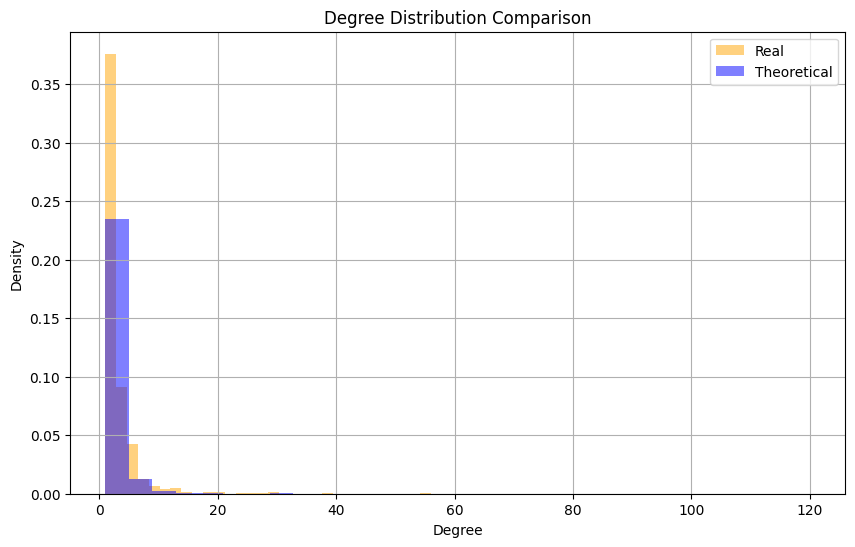

- Average degree: relative difference 25.21%
- Clustering: relative difference 100.00%
- Triangles: relative difference 100.00%
- Average path length: relative difference 0.52%
- Assortativity: absolute difference 0.1165
Barabasi-albert network number of nodes: 1458
Barabasi-albert network number of edges: 1457
Bio-yeast number of nodes: 1458
Bio-yeast number of edges: 1948


In [ ]:
m = compute_m(G_real_bio_yeast)
G_barabasi_albert_bio_yest = nx.barabasi_albert_graph(G_real_bio_yeast.number_of_nodes(), m, seed=SEED)
evaluate_graph_model(G_real_bio_yeast, G_barabasi_albert_bio_yest)

print(f"Barabasi-albert network number of nodes: {G_barabasi_albert_bio_yest.number_of_nodes()}")
print(f"Barabasi-albert network number of edges: {G_barabasi_albert_bio_yest.number_of_edges()}")

print(f"Bio-yeast number of nodes: {G_real_bio_yeast.number_of_nodes()}")
print(f"Bio-yeast number of edges: {G_real_bio_yeast.number_of_edges()}")

Number of communities: 2
New best modularity: 0.4991290006967053
Number of communities: 3
New best modularity: 0.6100469227910228
Number of communities: 4
New best modularity: 0.7045708385287884
Number of communities: 5
New best modularity: 0.7500472242726638
Number of communities: 6
New best modularity: 0.7934923774606674
Number of communities: 7
New best modularity: 0.8113330246286948
Number of communities: 8
New best modularity: 0.8282409629700463
Number of communities: 9
New best modularity: 0.8428548144498266
Number of communities: 10
New best modularity: 0.8557886123789303
Number of communities: 11
New best modularity: 0.8658962554567
Number of communities: 12
New best modularity: 0.8727092694770096
Number of communities: 13
New best modularity: 0.8793515224116271
Number of communities: 14
New best modularity: 0.8838765734161969
Number of communities: 15
New best modularity: 0.8878770934720274
Number of communities: 16
New best modularity: 0.891582255732744
Number of communities:

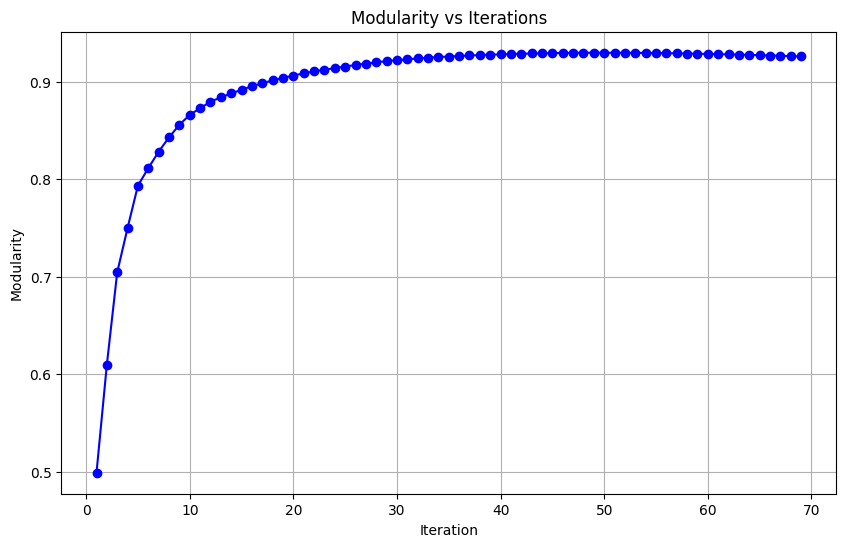

In [ ]:
barabasi_best_partition, barabasi_modularities, barabasi_partitions = communities_detection(G_barabasi_albert_bio_yest)
#barabasi_best_partition, barabasi_modularities, barabasi_partitions = load_communities('/content/drive/MyDrive/CSN_PROJECT/metrics/results/bio_yeast_barabasi_albert_communities.json')
plot_modularities(barabasi_modularities)


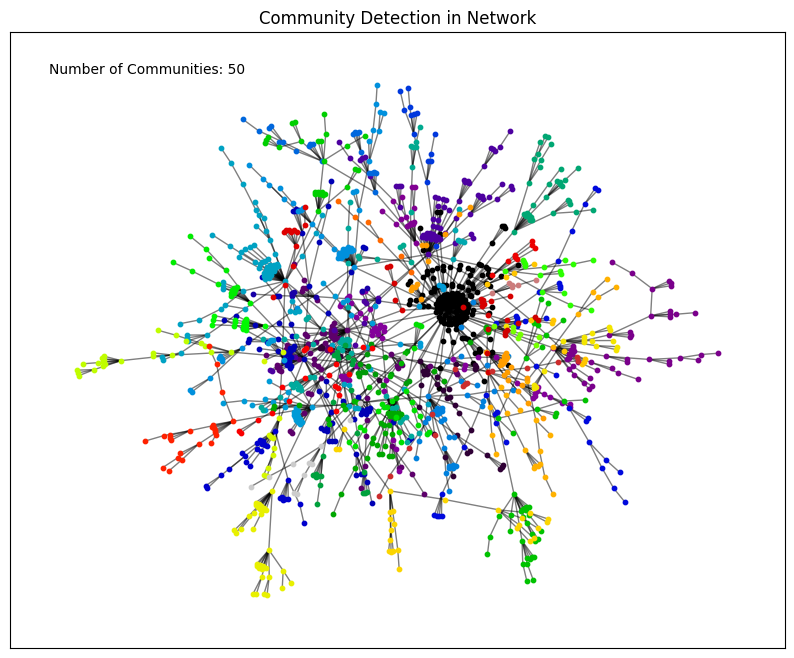

In [ ]:
plot_communities(G_barabasi_albert_bio_yest, barabasi_best_partition)

In [ ]:
save_community_metrics(G_barabasi_albert_bio_yest, barabasi_best_partition, base_path, 'bio_yeast_barabasi_albert')

Saved communities and metrics for bio_yeast_barabasi_albert


## Which is the best model?

#Phase 3: Hypothesis and Simulation 📊

##Phase 3 function

In [ ]:
def save_graph_metrics(G, metrics, base_path, file_prefix):
    #Ensure all values in metrics are JSON serializable
    def make_serializable(obj):
        if isinstance(obj, np.int64):
            return int(obj)
        elif isinstance(obj, np.float64):
            return float(obj)
        elif isinstance(obj, set):
            return list(obj)
        elif isinstance(obj, dict):
            return {k: make_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [make_serializable(i) for i in obj]
        else:
            return obj

    metrics_serializable = make_serializable(metrics)

    #Create directory if it doesn't exist
    os.makedirs(base_path + 'metrics/results/', exist_ok=True)

    #Save metrics
    results_path = base_path + f'metrics/results/{file_prefix}_metrics.json'
    with open(results_path, 'w') as f:
        json.dump(metrics_serializable, f, indent=4)

    print(f"Metrics saved to {results_path}")


def load_graph_metrics(base_path, file_prefix):
    results_path = base_path + f'metrics/results/{file_prefix}_metrics.json'
    with open(results_path, 'r') as f:
        metrics = json.load(f)
    return metrics


In [ ]:

def calculate_graph_metrics(G, metrics_to_compute):
    """
    Calculate selected metrics for a given graph.

    Parameters:
    G : networkx.Graph
        Input graph.
    metrics_to_compute : list
        List of metrics to compute. Options include:
        ['num_nodes', 'num_edges', 'avg_shortest_path_length', 'diameter',
         'num_components', 'largest_component_size', 'avg_clustering',
          'avg_degree', 'max_degree', 'betweenness_centrality',
         'degree_centrality', 'assortativity', 'modularity', 'degree_distribution',
         'connectivity', 'avg_path_length, global_efficiency']

    Returns:
    dict
        Dictionary containing calculated metrics and errors for unsupported metrics.
    """
    metrics = {}

    #Calculate requested metrics
    for metric in metrics_to_compute:
        try:
            if metric == 'num_nodes':
                metrics['num_nodes'] = G.number_of_nodes()

            elif metric == 'num_edges':
                metrics['num_edges'] = G.number_of_edges()

            elif metric == 'avg_shortest_path_length':
                if nx.is_connected(G):
                    metrics['avg_shortest_path_length'] = nx.average_shortest_path_length(G)
                else:
                    largest_cc = max(nx.connected_components(G), key=len)
                    subgraph = G.subgraph(largest_cc)
                    metrics['avg_shortest_path_length'] = "Infinite " + "but on Largest CC: " + str(nx.average_shortest_path_length(subgraph))

            elif metric == 'diameter':
                if nx.is_connected(G):
                    metrics['diameter'] = nx.diameter(G)
                else:
                    largest_cc = max(nx.connected_components(G), key=len)
                    subgraph = G.subgraph(largest_cc)
                    metrics['diameter'] = nx.diameter(subgraph)

            elif metric == 'num_components':
                metrics['num_components'] = nx.number_connected_components(G)

            elif metric == 'global_efficiency':
                metrics['global_efficiency'] = nx.global_efficiency(G)

            elif metric == 'largest_component_size':
                largest_component = max(nx.connected_components(G), key=len)
                metrics['largest_component_size'] = len(largest_component)

            elif metric == 'avg_clustering':
                metrics['avg_clustering'] = nx.average_clustering(G)

            elif metric == 'transitivity':
                metrics['transitivity'] = nx.transitivity(G)

            elif metric == 'avg_degree':
                degrees = [deg for _, deg in G.degree()]
                metrics['avg_degree'] = np.mean(degrees)

            elif metric == 'max_degree':
                degrees = [deg for _, deg in G.degree()]
                metrics['max_degree'] = np.max(degrees)

            elif metric == 'betweenness_centrality':
                metrics['betweenness_centrality'] = nx.betweenness_centrality(G)

            elif metric == 'degree_centrality':
                metrics['degree_centrality'] = nx.degree_centrality(G)

            elif metric == 'assortativity':
                metrics['assortativity'] = nx.degree_assortativity_coefficient(G)

            elif metric == 'degree_distribution':
                degrees = [deg for _, deg in G.degree()]
                metrics['degree_distribution'] = degrees

            elif metric == 'connectivity':
                metrics['connectivity'] = nx.node_connectivity(G)


            elif metric == 'modularity':
                partition = community_louvain.best_partition(G)
                metrics['partition'] = partition
                modularity = community_louvain.modularity(partition, G)
                metrics['modularity'] = modularity

            else:
                metrics[metric] = f"Funzione da aggiornare - metrica {metric} non calcolabile"

        except Exception as e:
            metrics[metric] = f"Errore nel calcolo: {str(e)}"

    return metrics


In [ ]:


def compare_graph_metrics(real_metrics, G_hypothesis, metrics_to_compute):
    """
    Compare metrics between precomputed real graph metrics and hypothesis graph metrics,
    print results, and plot degree distribution.

    Parameters:
    real_metrics : dict
        Precomputed metrics for the real graph.
    G_hypothesis : networkx.Graph
        Hypothesis graph.
    metrics_to_compute : list
        Metrics to compute for the hypothesis graph.
    """
    hypothesis_metrics = calculate_graph_metrics(G_hypothesis, metrics_to_compute)
    comparison = {}

    for metric in metrics_to_compute:
        if metric in real_metrics and metric in hypothesis_metrics:
            if metric == 'betweenness_centrality':
                #Print the comparison in a readable format
                print(f"Metric: {metric}\n")
                #Sort nodes by betweenness centrality in descending order
                sorted_real = sorted(real_metrics[metric].items(), key=lambda x: x[1], reverse=True)[:10]
                sorted_hypothesis = sorted(hypothesis_metrics[metric].items(), key=lambda x: x[1], reverse=True)[:10]

                print("Top 10 nodes by betweenness centrality:")
                print("Real Graph:")
                for node, value in sorted_real:
                    print(f"Node {node}: {value}")
                print("\nHypothesis Graph:")
                for node, value in sorted_hypothesis:
                    print(f"Node {node}: {value}")
                print("\n")
            elif metric == 'degree_distribution':
                #Plot degree distribution for real and hypothesis graphs
                plt.figure(figsize=(10, 6))
                plt.hist(real_metrics[metric], bins=50, alpha=0.5, label='Real Graph')
                plt.hist(hypothesis_metrics[metric], bins=50, alpha=0.5, label='Hypothesis Graph')
                plt.xlabel('Degree')
                plt.ylabel('Density')
                plt.title('Degree Distribution Comparison')
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                comparison[metric] = {
                    'real': real_metrics[metric],
                    'hypothesis': hypothesis_metrics[metric]
                }
        elif metric not in real_metrics:
            comparison[metric] = f"Metric {metric} not available in real metrics"
        elif metric not in hypothesis_metrics:
            comparison[metric] = f"Metric {metric} not available in hypothesis metrics"

    #Print all results

    print("\nComparison Results:")
    for metric, value in comparison.items():

        print(f"{metric}: {value}")

    return comparison


In [ ]:
def plot_graph(G, title=" ", node_size=15, edge_color='black'):
    """
    Plot a NetworkX graph with default NetworkX colors for nodes and edges.

    Parameters:
    G : networkx.Graph
        The input graph to be visualized.
    title : str
        Title of the plot (default: 'Graph Visualization').
    node_size : int
        Size of the nodes (default: 20).
    edge_color : str
        Color of the edges (default: 'black').
    """
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  #Positioning of nodes

    #Draw nodes and edges with specified edge color
    nx.draw_networkx_nodes(G, pos, node_size=node_size)

    #Explicitly set all edges to the same color
    nx.draw_networkx_edges(G, pos, edge_color=[edge_color] * len(G.edges()), alpha=0.6)

    #Add title
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
def plot_connected_components(G, title="Connected Components in Network"):
    """
    Plot the connected components of a graph with different colors.

    Parameters:
        G (networkx.Graph): The input graph.
        title (str): The title of the plot.
    """
    #Get connected components
    connected_components = list(nx.connected_components(G))
    colors = generate_colors(len(connected_components))  #Generate required number of colors

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)

    for i, component_nodes in enumerate(connected_components):
        color = colors[i % len(colors)]  #Cycle through colors if needed
        nx.draw_networkx_nodes(G, pos, nodelist=list(component_nodes),
                               node_color=[color], node_size=50)  #Adjust size as needed

    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title(title)
    plt.text(0.05, 0.95, f"Number of Connected Components: {len(connected_components)}",
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.show()

In [ ]:
#Random Rewiring Function
def random_rewiring(G, num_edges):
    edges = list(G.edges())
    nodes = list(G.nodes())

    for _ in range(num_edges):
        #Removes a random edge
        edge = random.choice(edges)
        G.remove_edge(*edge)

        #Removes a random edge
        while True:
            u, v = random.sample(nodes, 2)
            if not G.has_edge(u, v):
                G.add_edge(u, v)
                break
        edges = list(G.edges())  #Update edge
    return G

In [ ]:
import matplotlib.pyplot as plt
import re

def parse_numeric_value(value):
    """
    Extract numeric values from a string if present.
    If the value is already numeric, it is returned as is.
    """
    if isinstance(value, (int, float)):
        return value
    if isinstance(value, str):
        # Try to extract the first floating-point number from the string
        match = re.search(r"\d+\.\d+", value)
        if match:
            return float(match.group())
    return None  # Return None if no numeric value can be extracted

def plot_x_vs_y(results_list, x_key=None, y_metrics=None, x_label="", x_step=1):
    """
    Generalized function to plot metrics from simulation results.

    Parameters:
    - results_list: list of dicts containing simulation results.
    - x_key: str, optional, key to extract the X-axis values from results_list (e.g., 'iteration', 'num_edges_added').
             If None, X will be inferred as a sequence with step `x_step`.
    - y_metrics: list of str, metrics to plot on the y-axis (e.g., ['avg_path_length', 'modularity']).
    - x_label: str, label for the x-axis (e.g., 'Number of hubs removed').
    - x_step: int, step size for inferred X values if x_key is not provided. Default is 1.
    """
    if not results_list:
        print("Empty results_list: nothing to plot.")
        return

    # Extract X values
    if x_key:
        x_values = [result[x_key] for result in results_list]
    else:
        x_values = [i * x_step for i in range(len(results_list))]

    # Adjust X values to include the synthetic point at x=0
    x_values = [0] + [i * x_step for i in range(1, len(results_list) + 1)]

    # Prepare Y values, including the synthetic point for real values
    y_values = {}
    for metric in y_metrics:
        y_values[metric] = []
        # Add synthetic real value point at x=0
        if metric in results_list[0]:
            real_value = parse_numeric_value(results_list[0][metric]['real'])
            y_values[metric].append(real_value)
        else:
            y_values[metric].append(None)  # Placeholder if real value is missing

        # Add hypothesis values
        y_values[metric].extend([parse_numeric_value(result[metric]['hypothesis']) for result in results_list])

    # Plotting
    fig, axes = plt.subplots(1, len(y_metrics), figsize=(6 * len(y_metrics), 5))

    if len(y_metrics) == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot

    for i, (ax, metric) in enumerate(zip(axes, y_metrics)):
        color = 'blue' if i == 0 else 'red'  # First plot is blue, second is red
        ax.plot(x_values, y_values[metric], marker='o', color=color)
        ax.set_xlabel(x_label)
        ax.set_ylabel(metric.replace('_', ' ').capitalize())
        ax.set_title(f"{metric.replace('_', ' ').capitalize()} vs {x_label}")

        # Ensure proper ordering of Y-axis
        ax.set_ylim(bottom=min([v for v in y_values[metric] if v is not None]),
                    top=max([v for v in y_values[metric] if v is not None]))

    plt.tight_layout()
    plt.show()


In [ ]:
base_path = '/content/drive/MyDrive/CSN_PROJECT/'
metrics_list = [
        'num_nodes', 'num_edges', 'avg_shortest_path_length', 'diameter',
        'num_components', 'largest_component_size', 'avg_clustering',
        'avg_degree', 'max_degree', 'betweenness_centrality',
        'degree_centrality', 'assortativity', 'degree_distribution',
        'connectivity', 'largest_component_size', 'avg_path_length', 'modularity', 'global_efficiency'
    ]
metrics_real = calculate_graph_metrics(G_real_bio_yeast, metrics_list)
save_graph_metrics(G_real_bio_yeast, metrics_real, base_path, 'bio_yeast')


Metrics saved to /content/drive/MyDrive/CSN_PROJECT/metrics/results/bio_yeast_metrics.json


## Node Removal Hypotheses (Robustness)

### H1: Hub node removal reduce the connectivity

Iteration 1, Removal 1: Node 147 with degree 56
Iteration 1 results:


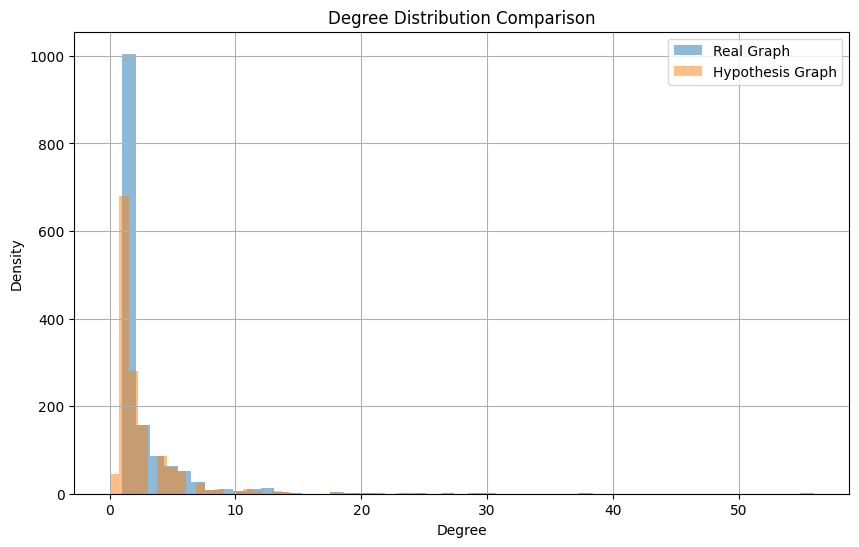

Metric: betweenness_centrality

Top 10 nodes by betweenness centrality:
Real Graph:
Node 819: 0.21299432211070685
Node 844: 0.13978458296207555
Node 98: 0.11592421803903051
Node 147: 0.09852765432525905
Node 595: 0.07847248516101055
Node 1275: 0.07594949597488405
Node 638: 0.06959572524518777
Node 567: 0.069194339657713
Node 1240: 0.06627325312176575
Node 253: 0.06570532488777518

Hypothesis Graph:
Node 819: 0.1807925760245925
Node 844: 0.13407695458389068
Node 98: 0.11419749337996603
Node 595: 0.07894096506357144
Node 1275: 0.0746773678313267
Node 567: 0.06843530726051791
Node 638: 0.0671551170519725
Node 1240: 0.06554507161788022
Node 27: 0.052258342681415
Node 961: 0.04562920057930534



Comparison Results:
connectivity: {'real': 1, 'hypothesis': 0}
largest_component_size: {'real': 1458, 'hypothesis': 1401}
num_components: {'real': 1, 'hypothesis': 50}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 'Infinite but on Largest CC: 6.855451208320587'}
global_efficien

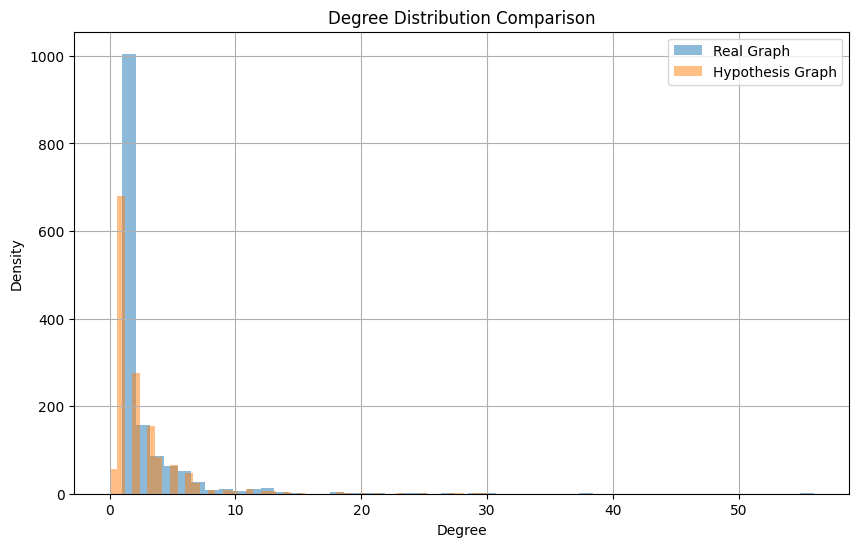

Metric: betweenness_centrality

Top 10 nodes by betweenness centrality:
Real Graph:
Node 819: 0.21299432211070685
Node 844: 0.13978458296207555
Node 98: 0.11592421803903051
Node 147: 0.09852765432525905
Node 595: 0.07847248516101055
Node 1275: 0.07594949597488405
Node 638: 0.06959572524518777
Node 567: 0.069194339657713
Node 1240: 0.06627325312176575
Node 253: 0.06570532488777518

Hypothesis Graph:
Node 98: 0.13374679833967726
Node 844: 0.11837546825826961
Node 595: 0.08118784760197895
Node 638: 0.07993089604836014
Node 1275: 0.07803526515976422
Node 567: 0.07530363291681391
Node 1240: 0.07021795913746827
Node 27: 0.05444080098096494
Node 302: 0.05346967444621728
Node 961: 0.04592804684837215



Comparison Results:
connectivity: {'real': 1, 'hypothesis': 0}
largest_component_size: {'real': 1458, 'hypothesis': 1375}
num_components: {'real': 1, 'hypothesis': 64}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 'Infinite but on Largest CC: 7.083386529045917'}
global_eff

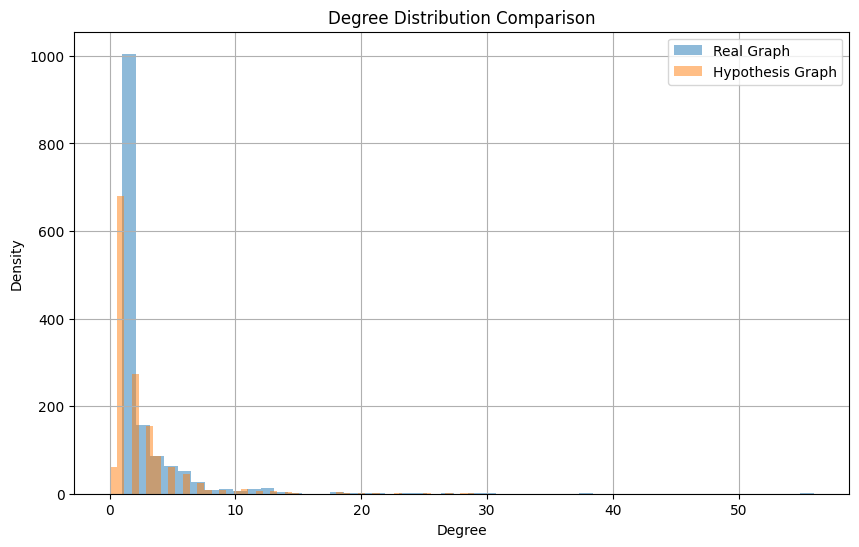

Metric: betweenness_centrality

Top 10 nodes by betweenness centrality:
Real Graph:
Node 819: 0.21299432211070685
Node 844: 0.13978458296207555
Node 98: 0.11592421803903051
Node 147: 0.09852765432525905
Node 595: 0.07847248516101055
Node 1275: 0.07594949597488405
Node 638: 0.06959572524518777
Node 567: 0.069194339657713
Node 1240: 0.06627325312176575
Node 253: 0.06570532488777518

Hypothesis Graph:
Node 844: 0.13427580197874198
Node 595: 0.09149794064080545
Node 638: 0.09107458545974233
Node 1275: 0.08043616953299382
Node 1240: 0.07988297903559485
Node 567: 0.07909805453264482
Node 27: 0.0657327144205737
Node 302: 0.05954959490453103
Node 961: 0.04816064148579102
Node 337: 0.04796859247946395



Comparison Results:
connectivity: {'real': 1, 'hypothesis': 0}
largest_component_size: {'real': 1458, 'hypothesis': 1360}
num_components: {'real': 1, 'hypothesis': 73}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 'Infinite but on Largest CC: 7.245631519716055'}
global_eff

In [ ]:
#Metrics to compute
metrics_list_hypothesis = ['connectivity', 'largest_component_size', 'num_components', 'degree_distribution', 'betweenness_centrality', 'avg_shortest_path_length', 'global_efficiency']
#Copy of the original graph
G_hypothesis_1 = G_real_bio_yeast.copy()
G_hypothesis_1_list = []
G_hypothesis_1_list.append(G_hypothesis_1)
removede_nodes = []
results_list_H1 = []

#Loop to remove hubs (1 in the first iteration, 2 in the second, etc.)
for i in range(3):  #Removes 1, 2 and 3 hubs respectively
    #Copy of the original graph for each iteration
    G_temp = G_hypothesis_1.copy()
    G_hypothesis_1_list.append(G_temp)

    #Removes nodes with the highest degree (increasing number for each iteration)
    for j in range(i + 1):  #i+1 determines how many nodes to remove
        #Find the node with the highest degree
        node_to_remove_tuple = max(G_temp.degree, key=lambda x: x[1])
        print(f"Iteration {i+1}, Removal {j+1}: Node {node_to_remove_tuple[0]} with degree {node_to_remove_tuple[1]}")

        #Remove the identified node
        node_to_remove_id = node_to_remove_tuple[0]
        G_temp.remove_node(node_to_remove_id)
        removede_nodes.append(node_to_remove_id)

    #Calculate metrics for the real graph
    real_metrics = load_graph_metrics(base_path, 'bio_yeast')

    #Print the comparison results
    print(f"Iteration {i+1} results:")
    #Compare the hypothesized graph with the real one
    results = compare_graph_metrics(real_metrics, G_temp, metrics_list_hypothesis)
    results_list_H1.append(results)


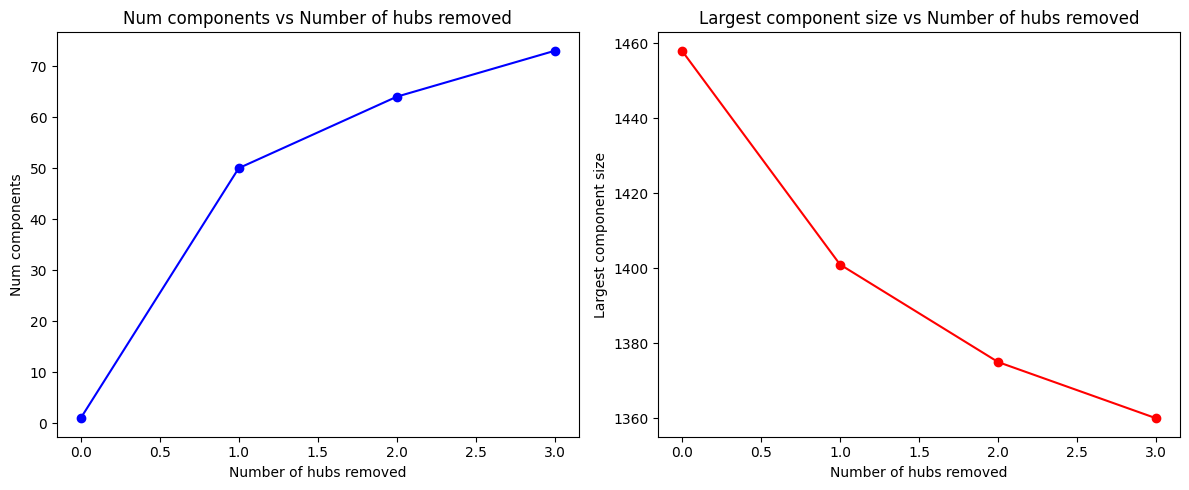

In [ ]:
plot_x_vs_y(results_list=results_list_H1, x_label="Number of hubs removed", y_metrics=["num_components", "largest_component_size"])

###Outcome
Removing a hub node significantly changes the degree distribution of the network. We can see an increase od nodes with degree 0 and a decrease of nodes with low degree. This means that by removing the hub, many connections are broken, isolating some nodes and reducing the overall connectivity of the network. The network's global connectivity drops from 1 (connected) to 0 (disconnected). This vulnerability is characteristic of scale-free networks, where the presence of highly connected hub nodes is crucial to maintaining the overall structure.

So, the significant changes are:
- **Size of the largest component**: The largest component shrinks slightly, but the network does not remains connected.
  
- **Number of components**: The number of components increases significantly, indicating that the network has split into many smaller components due to the removal of the hub.

- **Average shortest path length**: When the network becomes disconnected, the average shortest path length becomes infinite because we can’t reach the isolated nodes. However, we can calculate the average shortest path **within the largest component**, the part of the network that remains connected.


In conclusion, removing a hub node caused a drastic change in our network, leading to significant fragmentation. This highlights how vulnerable scale-free networks are to the loss of central nodes.


### H2: Remove a random node hasn't a significant impact on the robustess of the network


In [ ]:

#Set the seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)


#Copy of the original graph
G_hypothesis_2 = G_real_bio_yeast.copy()
results_list_H2 = []

for i in range(3):
    #Copy of the original graph for each iteration
    G_temp = G_hypothesis_2.copy()

    #Removes random nodes (increasing number for each iteration)
    for j in range(i + 1):  #i+1 determines how many nodes to remove
        #Select a random node
        node_to_remove_id = np.random.choice(list(G_temp.nodes()))
        node_degree = G_temp.degree(node_to_remove_id)
        print(f"Iteration {i+1}, Removal {j+1}: Node {node_to_remove_id} with degree {node_degree}")

        #Remove the identified node
        G_temp.remove_node(node_to_remove_id)

    #Calculate metrics for the real graph
    real_metrics = load_graph_metrics(base_path, 'bio_yeast')

    #Print the comparison results
    print(f"Iteration {i+1} results:")
    #Print the comparison results
    results = compare_graph_metrics(real_metrics, G_temp, metrics_list_hypothesis)
    results_list_H2.append(results)


Iteration 1, Removal 1: Node 762 with degree 1
Iteration 1 results:

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1947}
num_nodes: {'real': 1458, 'hypothesis': 1457}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.813735509514507}
diameter: {'real': 19, 'hypothesis': 19}
avg_clustering: {'real': 0.07083049680177282, 'hypothesis': 0.07087911073231624}
modularity: {'real': 0.81620634969157, 'hypothesis': 0.8192847489810221}
largest_component_size: {'real': 1458, 'hypothesis': 1457}
num_components: {'real': 1, 'hypothesis': 1}
Iteration 2, Removal 1: Node 251 with degree 4
Iteration 2, Removal 2: Node 680 with degree 2
Iteration 2 results:

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1942}
num_nodes: {'real': 1458, 'hypothesis': 1456}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 'Infinite but on Largest CC: 6.828714719910001'}
diameter: {'real': 19, 'hypothesis': 19}
avg_clustering: {'real': 0.07083049680177282, '

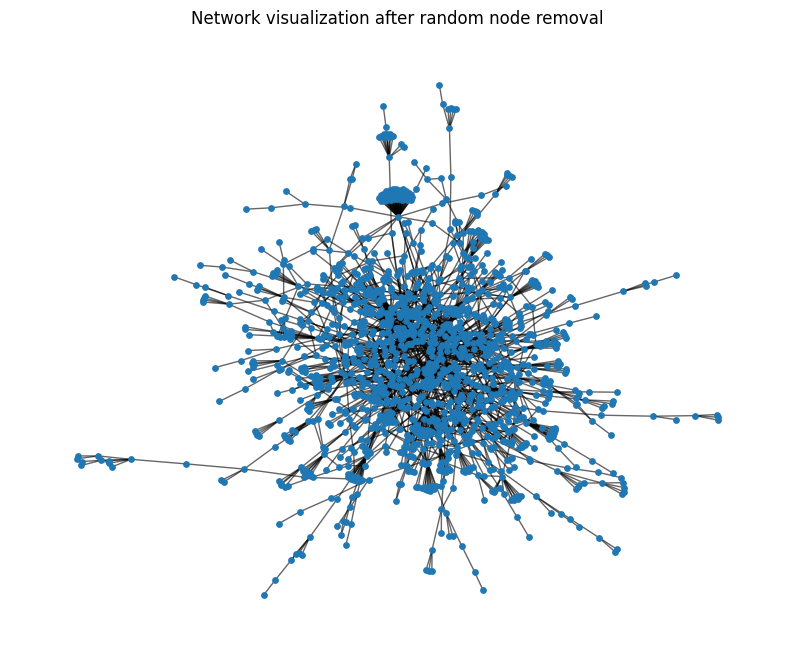

In [ ]:
plot_graph(G_hypothesis_2, title="Network visualization after random node removal")

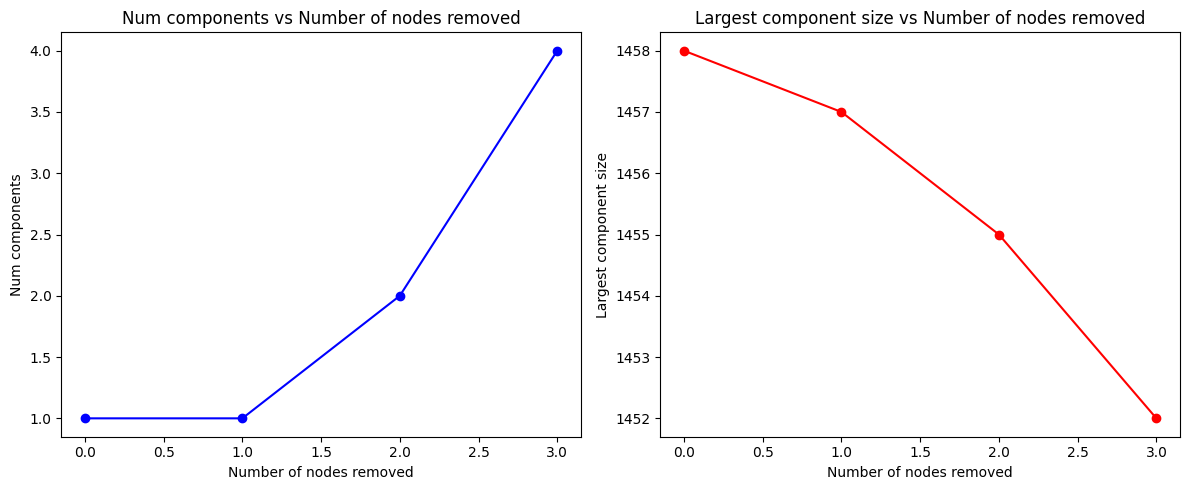

In [ ]:
plot_x_vs_y(results_list_H2, x_label="Number of nodes removed", y_metrics=["num_components", "largest_component_size"])

###Outcome
The random removal of a node can have two different impacts on the robustness of the network, depending on the degree of the node removed.

- **Removal of a low-degree node (few connections)**: When a node with low degree is removed, in a scale-free network, the impact on the network's robustness is minimal. This is because removing a node with few connections does not significantly alter the global structure of the network.

- **Removal of a high-degree node (hub)**: The removal of a hub leads to the same effect as in Hypothesis 1.


In conclusion, when removal occurs randomly and not on a specific critical node, it does not have a significant impact on the network's robustness.

## Edge Addition Hypotheses





### H3: Adding Random Edges decrese the average path lenght
Additional links might provide shortcuts, making the network more efficient in information or metabolite transfer.

In [ ]:

#Copy of the real graph
G_hypothesis_3 = G_real_bio_yeast.copy()
real_metrics = load_graph_metrics(base_path, 'bio_yeast')

#Parameters for adding edges
num_edges_to_add = 10  #Initial number of edges to add
max_number_of_iteration = 30  #Maximum number of iterations
results_list_H3 = []

metrics_list_hypothesis = ['num_edges', 'avg_shortest_path_length', 'diameter', 'avg_clustering', 'modularity']

for _ in range(max_number_of_iteration):
    #Adding random edges
    for _ in range(num_edges_to_add):
        node1, node2 = np.random.choice(list(G_hypothesis_3.nodes()), 2, replace=False)
        G_hypothesis_3.add_edge(node1, node2)

    print("After adding 10 more edges")
    results_list_H3.append(compare_graph_metrics(real_metrics, G_hypothesis_3, metrics_list_hypothesis))




After adding 10 more edges

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1958}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.770423846658626}
diameter: {'real': 19, 'hypothesis': 18}
avg_clustering: {'real': 0.07083049680177282, 'hypothesis': 0.07172539522753545}
modularity: {'real': 0.8189037932866436, 'hypothesis': 0.8157193557036895}
After adding 10 more edges

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1968}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.7522051907776}
diameter: {'real': 19, 'hypothesis': 18}
avg_clustering: {'real': 0.07083049680177282, 'hypothesis': 0.07172539522753545}
modularity: {'real': 0.8189037932866436, 'hypothesis': 0.8123193917724236}
After adding 10 more edges

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1978}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.695778291828013}
diameter: {'real': 19, 'hypothesis': 18}
avg_clustering: {'real':

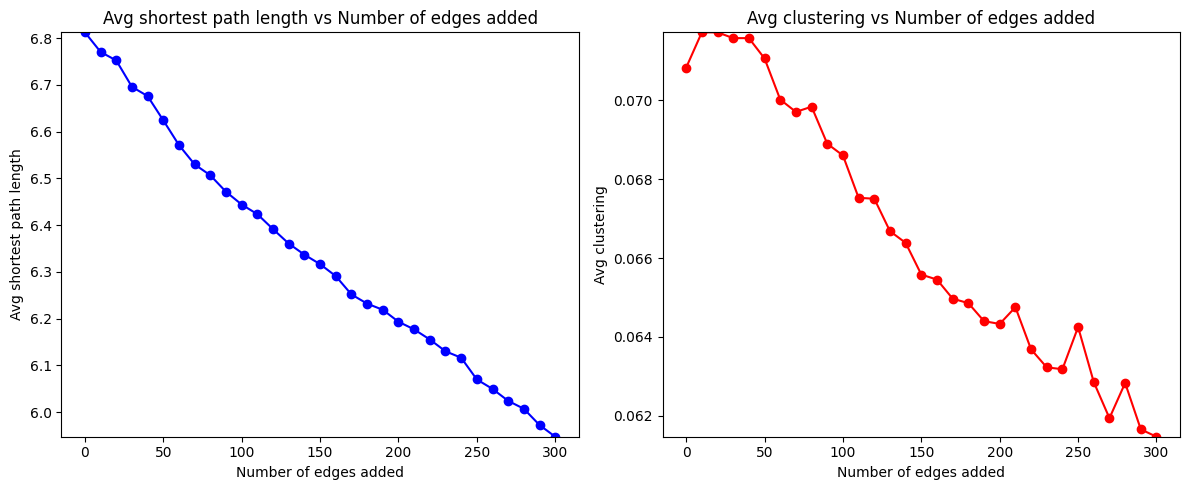

In [ ]:
plot_x_vs_y(results_list_H3, x_label="Number of edges added", y_metrics=["avg_shortest_path_length", "avg_clustering"], x_step=10)

###Outcome
Adding 10, 20, and 30 edges progressively reduced the average shortest path length from 6.81 to 6.79, 6.74, and 6.72, respectively. Further additions up to 300 edges continued to decrease the path length, reaching 5.96 with 300 additional edges. The network diameter decreased from 19 to 14, while average clustering coefficient showed a slight reduction from 0.0708 to 0.0599, indicating improved global efficiency at the cost of local connectivity.

### H4: Adding random edges between communities reduces the number of communities and modularity.

**Motivation:**  
In biological networks, such as protein interaction or metabolic networks, communities often represent functional modules responsible for specific biological processes. Adding random edges between communities can simulate mutations or nonspecific interactions that disrupt the modular organization of the system. This intervention compromises the efficiency and functional specialization of the communities, as the new connections blur the boundaries between functional modules, leading to a loss of modularity. Consequently, the network becomes less segmented, reducing its ability to isolate and maintain distinct biological processes, which may reflect phenomena of dysfunction or biological stress.  

#### Louvain Method vs Girvan Newman

**Computational Complexity:**
- **Louvain Method:** O(n log n)
- **Girvan-Newman Method:** O(n³)

---

##### **How the Louvain Method Works:**
1. **Initialization:** Each node is treated as a separate community.
2. **Local Optimization Phase:**
   - The modularity gain is calculated by merging a node with its neighbors.
   - Nodes are moved to the community that maximizes modularity.
3. **Aggregation:**
   - The identified communities are grouped into super-nodes.
   - The algorithm repeats until convergence.
4. **Goal:** Directly maximizes **modularity**, making it scalable for large graphs.

---

##### **How the Girvan-Newman Method Works:**
1. **Betweenness Centrality Calculation:**
   - Betweenness centrality is computed for all edges.
2. **Edge Removal:**
   - The edge with the highest centrality is removed.
3. **Repetition:**
   - The process continues until distinct communities are formed.
4. **Output:**
   - Produces a **hierarchical structure** (dendrogram) of communities.

---

##### **Comparison:**
- **Louvain Method:**
  - Fast and efficient, suitable for **large graphs**.
  - Directly optimizes **modularity**.
  - Does not provide a hierarchical structure.
- **Girvan-Newman Method:**
  - Computationally expensive, suitable only for **small graphs**.
  - Provides a **hierarchical dendrogram**, useful for detailed analysis.
  - Does not directly optimize modularity.

---

##### **Conclusion:**
- **Louvain** is ideal for large graphs and quick modularity analysis.
- **Girvan-Newman** is useful for small graphs or when a detailed hierarchical structure of communities is required.



In [ ]:

#Set the seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

#Copy of the original graph
G_hypothesis_4 = G_real_bio_yeast.copy()
metrics_list_hypothesis = ['num_edges', 'avg_shortest_path_length', 'diameter', 'avg_clustering', 'modularity']
#1. Identification of Initial Communities
modularity_initial = metrics_real['modularity']
partition_initial = metrics_real['partition']
print(f"Modularità iniziale: {modularity_initial}")

#Parameters
num_iterations = 30  # Numero di ripetizioni
results_list_H4 = []


communities = defaultdict(list)
for node, comm in partition_initial.items():
    communities[comm].append(node)
communities = list(communities.values())

total_edges_added = 0
for iteration in range(num_iterations):
    edges_added_this_iteration = 0
    #Selection of random nodes btw communities
    for i in range(len(communities) - 1):
        c1 = list(communities[i])
        c2 = list(communities[i + 1])
        node1 = random.choice(c1)
        node2 = random.choice(c2)
        G_hypothesis_4.add_edge(node1, node2)  #Incremental Adding
        edges_added_this_iteration += 1
    total_edges_added += edges_added_this_iteration
    print(f"Iteration {iteration+1}: {edges_added_this_iteration} edges added")
        # Show results

    print(f"Iteration {iteration+1}")
    # 3.Compare Metrics
    results = compare_graph_metrics(metrics_real, G_hypothesis_4, metrics_list_hypothesis)
    results_list_H4.append(results)
print(f"Total edges added: {total_edges_added}")



Modularità iniziale: 0.8191982826592009
Iteration 1: 34 edges added
Iteration 1

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1982}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.693870845349022}
diameter: {'real': 19, 'hypothesis': 19}
avg_clustering: {'real': 0.07083049680177282, 'hypothesis': 0.06745373925794808}
modularity: {'real': 0.8191982826592009, 'hypothesis': 0.8058794284789135}
Iteration 2: 34 edges added
Iteration 2

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 2016}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.5791256061979775}
diameter: {'real': 19, 'hypothesis': 17}
avg_clustering: {'real': 0.07083049680177282, 'hypothesis': 0.0646655694944697}
modularity: {'real': 0.8191982826592009, 'hypothesis': 0.797227955128811}
Iteration 3: 34 edges added
Iteration 3

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 2050}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.49

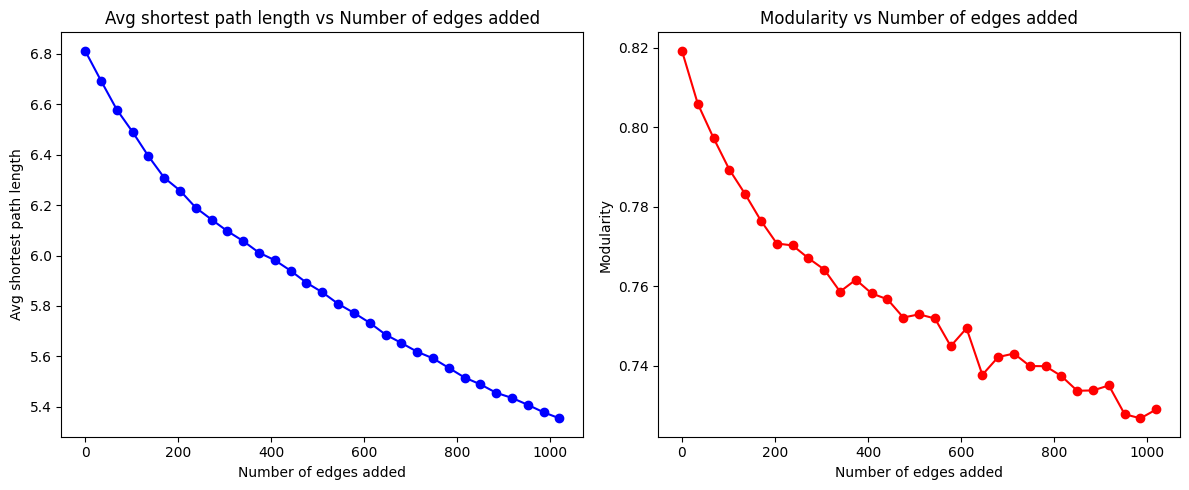

In [ ]:
plot_x_vs_y(results_list_H4, x_label="Number of edges added", y_metrics=["avg_shortest_path_length", "modularity"], x_step=34)

In [ ]:
res = calculate_graph_metrics(G_hypothesis_4, metrics_list_hypothesis)
print(res)
partition = res['partition']

communities_4 = defaultdict(list)
for node, comm in partition.items():
    communities_4[comm].append(node)
communities_4 = list(communities_4.values())

{'num_edges': 2257, 'avg_shortest_path_length': 6.0468868421027855, 'diameter': 15, 'avg_clustering': 0.058108308948037916, 'partition': {24: 0, 1: 0, 595: 0, 1143: 0, 1392: 1, 1405: 0, 156: 1, 2: 1, 951: 1, 1033: 1, 459: 1, 3: 1, 997: 1, 4: 0, 27: 11, 5: 11, 778: 11, 367: 4, 6: 4, 284: 5, 7: 5, 444: 5, 1141: 5, 807: 5, 8: 5, 819: 7, 1128: 4, 422: 7, 9: 7, 465: 7, 688: 7, 216: 7, 10: 7, 72: 9, 11: 9, 154: 9, 291: 9, 601: 9, 626: 9, 728: 9, 933: 9, 1203: 9, 1216: 9, 81: 4, 12: 9, 247: 9, 469: 9, 777: 10, 1074: 9, 1180: 4, 1197: 9, 1198: 9, 1199: 9, 1200: 11, 98: 12, 13: 4, 433: 4, 567: 8, 738: 4, 1273: 4, 329: 4, 14: 4, 942: 4, 1105: 5, 15: 5, 345: 8, 16: 8, 17: 4, 844: 14, 1240: 4, 1368: 15, 85: 7, 18: 7, 114: 7, 192: 14, 19: 14, 375: 4, 20: 4, 623: 4, 1067: 4, 1195: 4, 1361: 4, 1362: 4, 706: 7, 21: 7, 165: 12, 22: 12, 202: 12, 288: 12, 426: 12, 810: 12, 1115: 12, 585: 11, 23: 11, 152: 7, 690: 0, 913: 0, 1439: 0, 1440: 0, 166: 1, 25: 1, 263: 1, 347: 1, 472: 1, 620: 1, 638: 1, 784: 1, 7

Real network


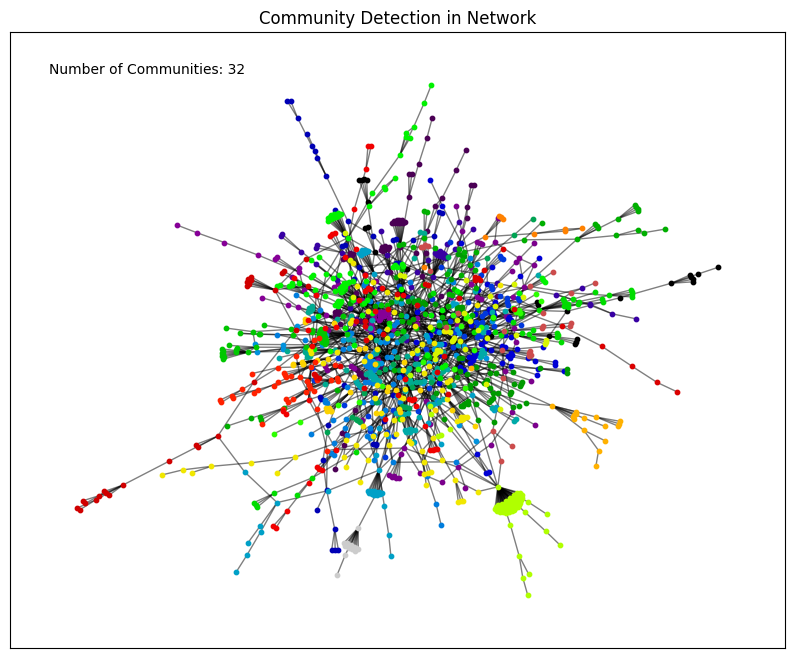

Real network after rewiring


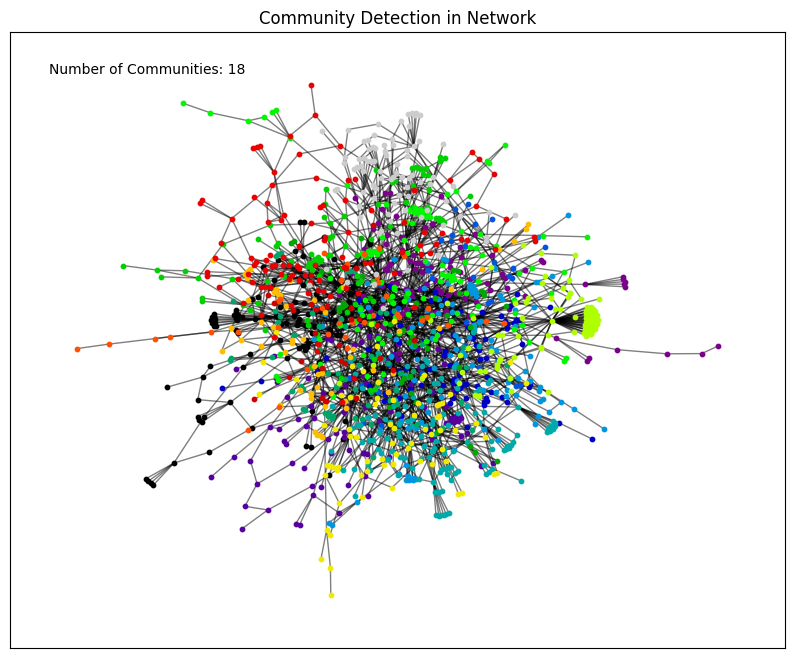

In [ ]:
print("Real network")
plot_communities(G_real_bio_yeast, communities)
print("Real network after rewiring")
plot_communities(G_hypothesis_4, communities_4)


While the Louvain algorithm provides an efficient and scalable solution for community detection, its trade-off lies in the loss of granularity. This makes it ideal for analyzing large-scale networks but less suitable for applications requiring detailed hierarchical structures.

### Outcome
Modularity dropped from 0.82 to 0.76 after adding random edges incrementally. The average shortest path length decreased from 6.81 to 6.04, while the network diameter reduced from 19 to 14, indicating improved global connectivity. However, the average clustering coefficient decreased slightly from 0.071 to 0.059, suggesting a loss of local cohesiveness.

## Rewiring Hypotheses (Plasticity)

### H5: Random rewiring reduces modularity but improves average path length.

Simulates nonspecific changes, such as random mutations or errors during genetic replication.

In [ ]:
# Load the network
G_hypothesis_5 = G_real_bio_yeast.copy()

# 1. Communities identifcation
modularity_initial = metrics_real['modularity']
partition_initial = metrics_real['partition']
print(f"Modularità iniziale: {modularity_initial}")
results_list_H5 = []


# 3. Application of Random Rewiring
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # 10%, 30%, 50% di rewiring
metrics_list_hypothesis = ['num_edges', 'num_nodes', 'avg_shortest_path_length', 'diameter', 'avg_clustering', 'modularity', 'largest_component_size', 'num_components']

for p in percentages:
    G_copy = G_hypothesis_5.copy()
    num_edges = int(p * len(G_copy.edges()))
    G_rewired = random_rewiring(G_copy, num_edges)

    print(f"Random Rewiring results with {int(p*100)}% edges")
    # 4. Show results
    results = compare_graph_metrics(metrics_real, G_rewired, metrics_list_hypothesis)
    results_list_H5.append(results)


Modularità iniziale: 0.8189037932866436
Random Rewiring results with 10% edges

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1948}
num_nodes: {'real': 1458, 'hypothesis': 1458}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 'Infinite but on Largest CC: 6.367217011712841'}
diameter: {'real': 19, 'hypothesis': 15}
avg_clustering: {'real': 0.07083049680177282, 'hypothesis': 0.04493675665748615}
modularity: {'real': 0.8189037932866436, 'hypothesis': 0.7671587823450788}
largest_component_size: {'real': 1458, 'hypothesis': 1361}
num_components: {'real': 1, 'hypothesis': 75}
Random Rewiring results with 20% edges

Comparison Results:
num_edges: {'real': 1948, 'hypothesis': 1948}
num_nodes: {'real': 1458, 'hypothesis': 1458}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 'Infinite but on Largest CC: 6.476373828473939'}
diameter: {'real': 19, 'hypothesis': 18}
avg_clustering: {'real': 0.07083049680177282, 'hypothesis': 0.03709141440197367

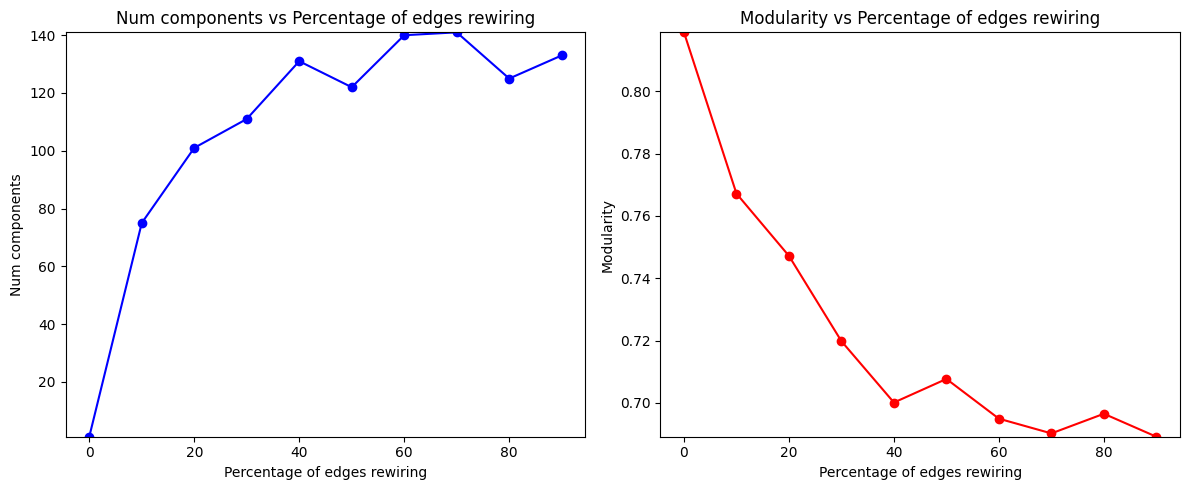

In [ ]:
plot_x_vs_y(results_list_H5, x_label="Percentage of edges rewiring", y_metrics=["num_components", "modularity"],x_step=10)

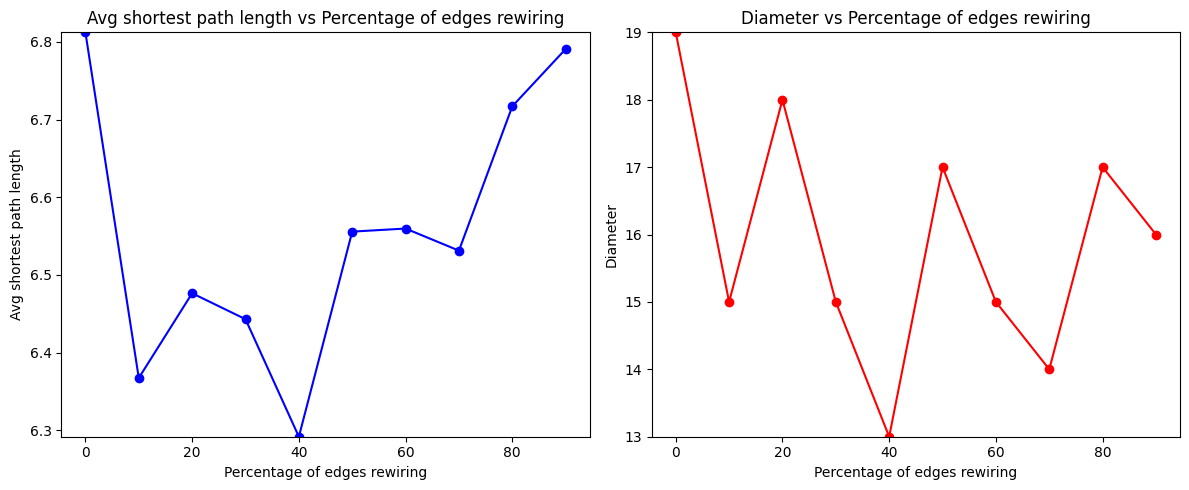

In [ ]:
plot_x_vs_y(results_list_H5, x_label="Percentage of edges rewiring", y_metrics=["avg_shortest_path_length", "diameter"],x_step=10)

### Outcome
Rewiring progressively reduced **modularity** from 0.82 to 0.68 as 90\% of edges were rewired. The **average path length** (largest connected component) initially decreased from 6.81 to 6.31 but then increased to 6.67, reflecting a temporary improvement in efficiency followed by a decline as structural coherence was disrupted. The network diameter oscillated, dropping from 19 to a minimum of 13 before stabilizing around 16, indicating inconsistent global efficiency. However, the clustering coefficient fell sharply from 0.071 to 0.007, and the number of connected components increased significantly, highlighting a significant loss of local cohesion and fragmentation into smaller subgraphs. \\



# Phase 4: Comparative Strategies for Reconnecting Graph Components 📊

The results of Phase 3 highlighted the need for targeted strategies to mitigate network fragmentation.

##Phase 4 function

In [ ]:



# Step 1: Identify the connected components
def identify_connected_components(graph):
    return list(nx.connected_components(graph))

# Step 2: Select a representative node for each CC
def select_representative_nodes(graph, connected_components, original_hub_neighbors):
    representative_nodes = []
    for component in connected_components:
        subgraph = graph.subgraph(component)

        # Find orphan nodes (nodes previously connected to the hub)
        orphan_nodes = [node for node in subgraph.nodes if node in original_hub_neighbors]

        if orphan_nodes:
            # Select the orphan node with the highest degree
            representative_node = max(orphan_nodes, key=lambda n: subgraph.degree[n])
        else:
            # Raise an error if no orphan nodes exist, as the graph is assumed to be connected
            raise ValueError("No orphan nodes found in a connected component. Check the initial graph connectivity.")

        representative_nodes.append(representative_node)
    return representative_nodes


In [ ]:
# Step 3: Fully connect all representative nodes
def fully_connect_representatives(graph, representative_nodes):
    for node1, node2 in combinations(representative_nodes, 2):
        graph.add_edge(node1, node2)

In [ ]:
def connect_representatives_with_spanning_tree(graph, representative_nodes):
    """
    Step 3: Connect representative nodes using a minimum spanning tree.

    Parameters:
        graph (networkx.Graph): The graph where the spanning tree edges will be added.
        representative_nodes (list): A list of representative nodes for each connected component.

    Returns:
        None: The graph is modified in-place.
    """
    # Create a complete graph for representative nodes
    complete_graph = nx.Graph()
    for i, node1 in enumerate(representative_nodes):
        for node2 in representative_nodes[i + 1:]:
            complete_graph.add_edge(node1, node2)

    # Compute the minimum spanning tree (MST) of the complete graph
    mst = nx.minimum_spanning_tree(complete_graph)

    # Add the edges of the MST to the original graph
    for edge in mst.edges:
        graph.add_edge(*edge)

    # Print details about the edges added
    print(f"Number of Edges Added (Spanning Tree): {len(mst.edges)}")


## Barabasi: Hub Removal, edge addition.

The central experiment involves the removal of the hub with the highest degree from the network
and the evaluation of its impact. The primary goal is to mitigate the resulting fragmentation by
employing edge-adding strategies. Additionally, we introduce a novel metric, network efficiency,
to assess the effectiveness of these strategies in comparison to the Average Path Length (APL),
which has certain limitations in fragmented networks.


### Network's efficiency

The efficiency of a network is a measure of how efficiently it exchanges informationan, since this definition it's also called communication efficiency. The main idea is that the more distant two nodes are in the network, the less efficient their communication will be. The concept of efficiency can be applied to both local and global scales in a network. On a global scale, efficiency quantifies the exchange of information across the whole network. The local efficiency quantifies a network's resistance to failure on a small scale.

The definition of communication efficiency assumes that the efficiency is inversely proportional to the distance, so in mathematical terms
$$e_{ij} = \frac{1}{d{ij}}$$

where $e{ij}$ is the pairwise efficiency of nodes $i,j$ in graph $G$.

The average communication efficiency of the network $G$ is then defined as the average over the pairwise efficiencies:

$$E(G) = \frac{1} {N(N-1)} \sum_{i \neq j} \frac{1}{d_{ij}}$$

where  $N = |V|$ denotes the number of nodes in the network.

In [ ]:
m = compute_m(G_real_bio_yeast)
G_barabasi_albert_bio_yest = nx.barabasi_albert_graph(G_real_bio_yeast.number_of_nodes(), m, seed=SEED)

base_path = '/content/drive/MyDrive/CSN_PROJECT/'

metrics_list = [
        'num_nodes', 'num_edges', 'avg_shortest_path_length', 'diameter',
        'num_components', 'largest_component_size', 'largest_component_size', 'global_efficiency'
    ]

ba_metrics = calculate_graph_metrics(G_barabasi_albert_bio_yest, metrics_list)
save_graph_metrics(G_barabasi_albert_bio_yest, ba_metrics, base_path, 'barabasi_albert_bio_yeast')


Metrics saved to /content/drive/MyDrive/CSN_PROJECT/metrics/results/barabasi_albert_bio_yeast_metrics.json


### Hub Removal

In [ ]:
G_hub_rem_ba = G_barabasi_albert_bio_yest.copy()
node_to_remove_tuple = max(G_hub_rem_ba.degree, key=lambda x: x[1])
print(f" Removal: Node {node_to_remove_tuple[0]} with degree {node_to_remove_tuple[1]}")

node_to_remove_id = node_to_remove_tuple[0]
original_hub_neighbors = list(G_hub_rem_ba.neighbors(node_to_remove_id))
G_hub_rem_ba.remove_node(node_to_remove_id)

result_metrics = compare_graph_metrics(ba_metrics, G_hub_rem_ba, metrics_list)

 Removal: Node 0 with degree 120

Comparison Results:
num_nodes: {'real': 1458, 'hypothesis': 1457}
num_edges: {'real': 1457, 'hypothesis': 1337}
avg_shortest_path_length: {'real': 6.777247722314958, 'hypothesis': 'Infinite but on Largest CC: 6.2943331178625295'}
diameter: {'real': 17, 'hypothesis': 15}
num_components: {'real': 1, 'hypothesis': 120}
largest_component_size: {'real': 1458, 'hypothesis': 715}
global_efficiency: {'real': 0.16683484185406386, 'hypothesis': 0.0492364954122803}


### Analysis of Orphaned Nodes

### Key Observations from the Results

#### **Removed Node (Hub):**
- The removed node is **Node 0**, with a degree of **120**.
- This node was a **central hub**, connected to many other nodes. Its removal caused significant network fragmentation.

#### **Network Fragmentation:**
- The network went from **1 connected component** to **120 components**. This indicates that many nodes (at least 119) became orphaned and disconnected from the main component.
- The size of the **Largest Connected Component (LCC)** dropped from **1458** to **715**, showing that only **49%** of the nodes remained in the main component.
- Notably, the 120 connected components were all previously held together by the hub, and there are no edges between these components.

#### **Global Efficiency:**
- The **global_efficiency** dropped drastically from **0.1668** to **0.0492**, highlighting a significant reduction in the overall communication capacity of the network.

---

### What Happens to Orphaned Nodes?

#### **Degree of Orphaned Nodes:**
- Since the removed node was a hub with a degree of **120**, the orphaned nodes are likely **its direct neighbors**.
- These nodes had a high degree of dependency on the removed node to stay connected to the network.

#### **Were They Hubs or Peripheral Nodes?**
- It is unlikely that the orphaned nodes were significant hubs; otherwise, they would have remained connected to the LCC through other connections.
- It is more likely that the orphaned nodes had a **low degree** and were directly connected only to the removed node (hub), making them vulnerable to fragmentation.


---

### Conclusions

- The removal of Node 0 caused drastic fragmentation of the network, isolating nodes that were heavily dependent on it.
- The orphaned nodes are primarily peripheral nodes with few connections and a high dependency on the removed hub.
- To improve the robustness of the network, it is necessary to add strategic edges to reconnect the orphaned nodes to the LCC and restore the overall communication capacity.



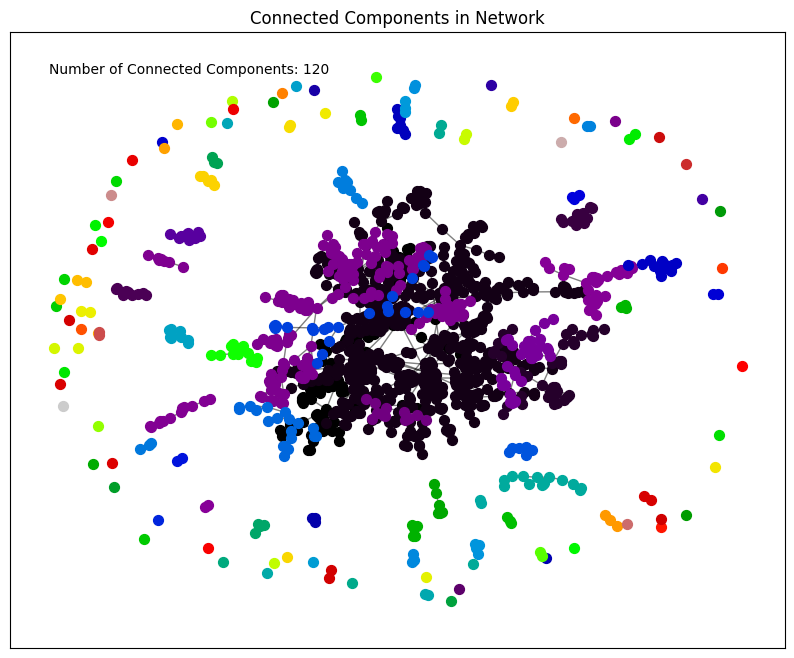

In [ ]:
plot_connected_components(G_hub_rem_ba)

#### Observations
$k = |CCs|$ \\
$n = $ number of orphan node

1. **Case \(k = n\):**  
   - When \(k = n\), each node disconnected by removing the hub forms its own individual CC. This represents the simplest case where there are exactly \(n\) disjoint CCs.

2. **Case \(k < n\):**  
   - If \(k < n\), some "orphan" nodes (nodes disconnected from the hub) remain connected to each other within a single CC. This occurs when those nodes have existing edges independent of the hub. If **\(k << n\):**  Many orphan nodes are already well-connected to the Largest Connected Component (LCC) or to each other through existing edges.The removal of the hub has a less significant impact on the network’s overall structure, as sufficient redundancy exists to preserve connectivity and efficiency.


---

#### Generalization

The solution must handle both cases (\(k = n\) and \(k < n\)) and treat each CC as a unit, regardless of whether the CC consists of a single node or multiple nodes.

---

### Proposed Solution

#### 1. Identify the CCs
   - After removing the hub, determine all \(k\) connected components in the graph.

#### 2. Select a Representative Node for Each CC
   - **Single-node CC:** The single node itself acts as the representative.
   - **Multi-node CC:** Select a representative node using a chosen criterion:
     - The orphan node, if available.
     - If there are multiple orphan nodes, choose the one with the highest degree within the CC.
     - In case of a tie (equal degree), select one randomly.

#### 3. Connect All Representatives
Once the representative nodes are selected, there are multiple strategies to connect them:
- Fully connected
- Spanning Tree
- Other solution.

---


## **Proposed Approach:**

1. **Fully Connected Network between CCs (Trivial)**  
   Consider the connected components (CCs) created after removing the hub. Fully connect all the nodes that were previously connected to the hub.  
   - **Advantages:** This solution is the simplest and most resilient since all disjoint nodes are connected to each other. Useful when k << n.
   - **Disadvantages:** The number of edges added is very high, leading to increased complexity and redundancy.  

2. **Spanning Tree**  
   Consider the CCs generated after removing the hub. For each CC, select a representative node (e.g., a node that was previously connected to the hub). Treat these CCs as single nodes and construct a spanning tree over them.  
   - **Advantages:** Since the number of CCs is significantly smaller than the total number of nodes, the probability of a random attack removing the edge connecting two CCs is low. It is also effective when the removal of the hub has a small impact on the network structure. The minimal edge addition makes it ideal for generalizing across cases.
   - **Disadvantages:** This approach is less resilient to targeted attacks. However, in scenarios where an adversary has infinite resources, the robustness of any solution becomes irrelevant.
   when the remotion of the hub has a small impact in the network, this is also the best solution.



### Fully Connected Network between CCs


In [ ]:
G_temp = G_hub_rem_ba.copy()
# Step 1: Identify connected components
connected_components = identify_connected_components(G_temp)
print(f"Number of Connected Components: {len(connected_components)}")

# Calculate internal edges before reconnection
internal_edges = sum(G_temp.subgraph(cc).number_of_edges() for cc in connected_components)
print(f"Number of Internal Edges in CCs: {internal_edges}")

# Step 2: Select representative nodes for each CC
representative_nodes = select_representative_nodes(G_temp, connected_components, original_hub_neighbors)

# Step 3: Fully connect the representative nodes
fully_connect_representatives(G_temp, representative_nodes)

# Calculate edges added between representatives
representative_edges = len(representative_nodes) * (len(representative_nodes) - 1) // 2
print(f"Number of Edges Added Between Representatives: {representative_edges}")

    # Print results
print("Graph Info After Reconnection:")
print(f"Number of Nodes: {G_temp.number_of_nodes()}")
print(f"Number of Edges: {G_temp.number_of_edges()}")

result_metrics = compare_graph_metrics(ba_metrics, G_temp, metrics_list)

Number of Connected Components: 120
Number of Internal Edges in CCs: 1337
Number of Edges Added Between Representatives: 7140
Graph Info After Reconnection:
Number of Nodes: 1457
Number of Edges: 8477

Comparison Results:
num_nodes: {'real': 1458, 'hypothesis': 1457}
num_edges: {'real': 1457, 'hypothesis': 8477}
avg_shortest_path_length: {'real': 6.777247722314958, 'hypothesis': 6.04566247067963}
diameter: {'real': 17, 'hypothesis': 16}
num_components: {'real': 1, 'hypothesis': 1}
largest_component_size: {'real': 1458, 'hypothesis': 1457}
global_efficiency: {'real': 0.16683484185406386, 'hypothesis': 0.19490752356385757}


We add $ \frac{(120 \cdot 119) }{2}= 7140$ edges \\
We obtained $ (1457 - 120) + 7140$  = 8477 total edges

### Spanning Tree


In [ ]:
G_temp = G_hub_rem_ba.copy()
# Step 1: Identify connected components
connected_components = identify_connected_components(G_temp)
print(f"Number of Connected Components: {len(connected_components)}")

# Calculate internal edges before reconnection
internal_edges = sum(G_temp.subgraph(cc).number_of_edges() for cc in connected_components)
print(f"Number of Internal Edges in CCs: {internal_edges}")

# Step 2: Select representative nodes for each CC
representative_nodes = select_representative_nodes(G_temp, connected_components, original_hub_neighbors)

# Step 3: Connect the rappresentative nodes with a spanning tree
connect_representatives_with_spanning_tree(G_temp, representative_nodes)

    # Print results
print("Graph Info After Reconnection:")
print(f"Number of Nodes: {G_temp.number_of_nodes()}")
print(f"Number of Edges: {G_temp.number_of_edges()}")

result_metrics = compare_graph_metrics(ba_metrics, G_temp, metrics_list)

Number of Connected Components: 120
Number of Internal Edges in CCs: 1337
Number of Edges Added (Spanning Tree): 119
Graph Info After Reconnection:
Number of Nodes: 1457
Number of Edges: 1456

Comparison Results:
num_nodes: {'real': 1458, 'hypothesis': 1457}
num_edges: {'real': 1457, 'hypothesis': 1456}
avg_shortest_path_length: {'real': 6.777247722314958, 'hypothesis': 6.651129069969152}
diameter: {'real': 17, 'hypothesis': 16}
num_components: {'real': 1, 'hypothesis': 1}
largest_component_size: {'real': 1458, 'hypothesis': 1457}
global_efficiency: {'real': 0.16683484185406386, 'hypothesis': 0.16992055864111455}


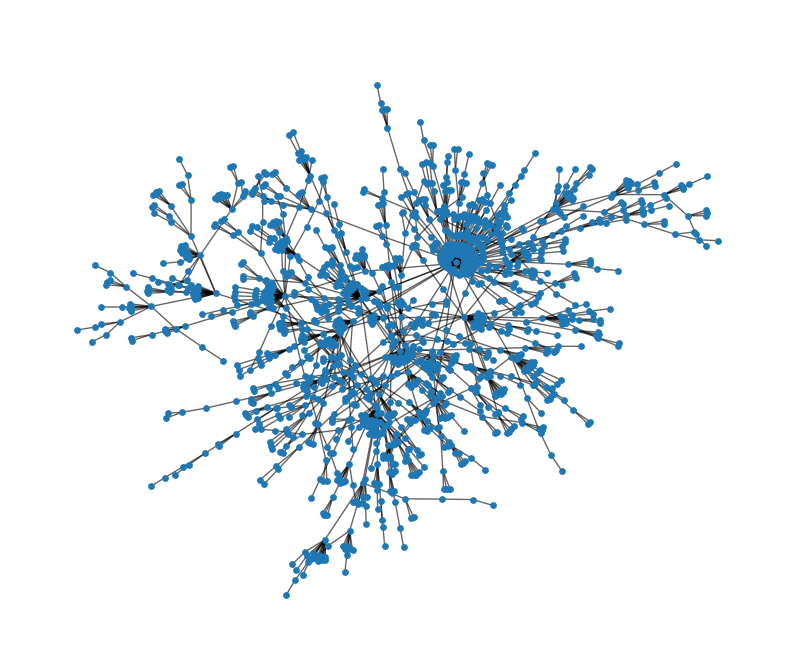

In [ ]:
plot_graph(G_temp)

## Real model: Hub Removal, edge addition.

In [ ]:

metrics_list = [
        'num_nodes', 'num_edges', 'avg_shortest_path_length', 'diameter',
        'num_components', 'largest_component_size', 'largest_component_size', 'global_efficiency'
    ]

### Hub Removal

In [ ]:
G_hub_rem_real = G_real_bio_yeast.copy()
node_to_remove_tuple = max(G_hub_rem_real.degree, key=lambda x: x[1])
print(f" Removal: Node {node_to_remove_tuple[0]} with degree {node_to_remove_tuple[1]}")

node_to_remove_id = node_to_remove_tuple[0]
original_hub_neighbors = list(G_hub_rem_real.neighbors(node_to_remove_id))
G_hub_rem_real.remove_node(node_to_remove_id)

result_metrics = compare_graph_metrics(metrics_real, G_hub_rem_real, metrics_list)

 Removal: Node 147 with degree 56

Comparison Results:
num_nodes: {'real': 1458, 'hypothesis': 1457}
num_edges: {'real': 1948, 'hypothesis': 1892}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 'Infinite but on Largest CC: 6.855451208320587'}
diameter: {'real': 19, 'hypothesis': 19}
num_components: {'real': 1, 'hypothesis': 50}
largest_component_size: {'real': 1458, 'hypothesis': 1401}
global_efficiency: {'real': 0.16378182452297826, 'hypothesis': 0.15083822469491184}


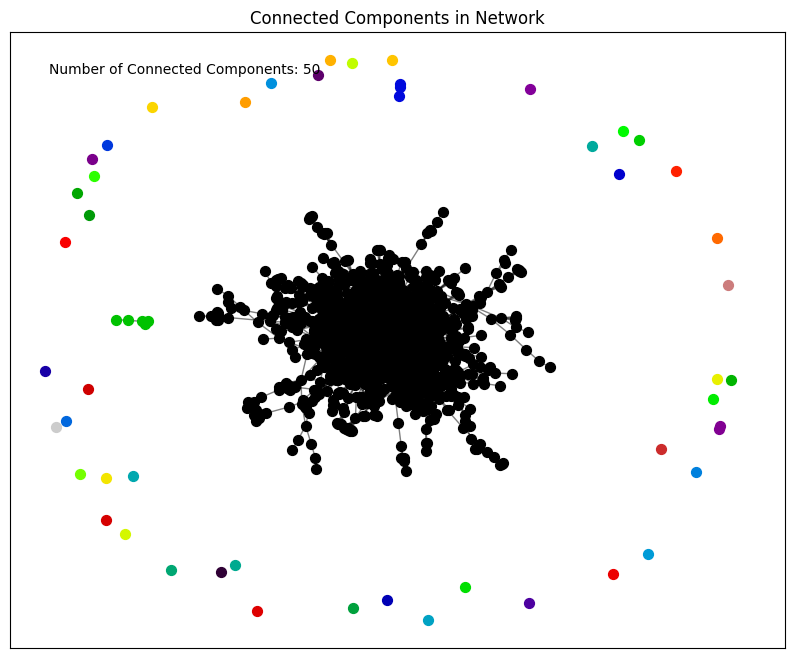

In [ ]:
plot_connected_components(G_hub_rem_real)

### Fully Conncetion between CCs

In [ ]:
G_temp = G_hub_rem_real.copy()
# Step 1: Identify connected components
connected_components = identify_connected_components(G_temp)
print(f"Number of Connected Components: {len(connected_components)}")

# Calculate internal edges before reconnection
internal_edges = sum(G_temp.subgraph(cc).number_of_edges() for cc in connected_components)
print(f"Number of Internal Edges in CCs: {internal_edges}")

# Step 2: Select representative nodes for each CC
representative_nodes = select_representative_nodes(G_temp, connected_components, original_hub_neighbors)

# Step 3: Fully connect the representative nodes
fully_connect_representatives(G_temp, representative_nodes)

# Calculate edges added between representatives
representative_edges = len(representative_nodes) * (len(representative_nodes) - 1) // 2
print(f"Number of Edges Added Between Representatives: {representative_edges}")

    # Print results
print("Graph Info After Reconnection:")
print(f"Number of Nodes: {G_temp.number_of_nodes()}")
print(f"Number of Edges: {G_temp.number_of_edges()}")

result_metrics = compare_graph_metrics(metrics_real, G_temp, metrics_list)

Number of Connected Components: 50
Number of Internal Edges in CCs: 1892
Number of Edges Added Between Representatives: 1225
Graph Info After Reconnection:
Number of Nodes: 1457
Number of Edges: 3117

Comparison Results:
num_nodes: {'real': 1458, 'hypothesis': 1457}
num_edges: {'real': 1948, 'hypothesis': 3117}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.807299169601847}
diameter: {'real': 19, 'hypothesis': 19}
num_components: {'real': 1, 'hypothesis': 1}
largest_component_size: {'real': 1458, 'hypothesis': 1457}
global_efficiency: {'real': 0.16378182452297826, 'hypothesis': 0.16475465793310182}


We added $\frac{50 \cdot 49}{2} = 1225$ edges. \\
So we obtain (1948 - 56) + 1225 = 3117 edges

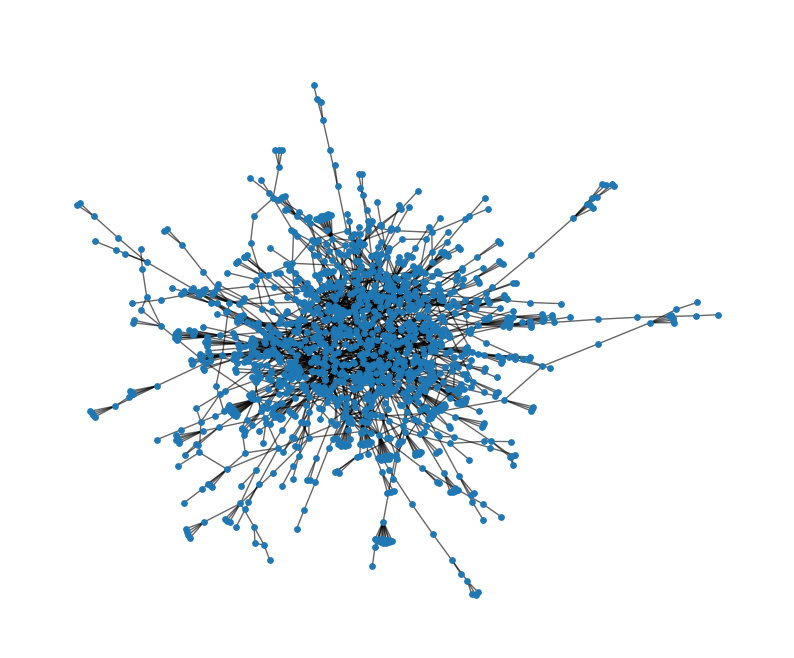

In [ ]:
plot_graph(G_temp)

### Spanning Tree

In [ ]:
G_temp = G_hub_rem_real.copy()
# Step 1: Identify connected components
connected_components = identify_connected_components(G_temp)
print(f"Number of Connected Components: {len(connected_components)}")

# Calculate internal edges before reconnection
internal_edges = sum(G_temp.subgraph(cc).number_of_edges() for cc in connected_components)
print(f"Number of Internal Edges in CCs: {internal_edges}")

# Step 2: Select representative nodes for each CC
representative_nodes = select_representative_nodes(G_temp, connected_components, original_hub_neighbors)

# Step 3:
connect_representatives_with_spanning_tree(G_temp, representative_nodes)

# Print results
print("Graph Info After Reconnection:")
print(f"Number of Nodes: {G_temp.number_of_nodes()}")
print(f"Number of Edges: {G_temp.number_of_edges()}")

result_metrics = compare_graph_metrics(metrics_real, G_temp, metrics_list)

Number of Connected Components: 50
Number of Internal Edges in CCs: 1892
Number of Edges Added (Spanning Tree): 49
Graph Info After Reconnection:
Number of Nodes: 1457
Number of Edges: 1941

Comparison Results:
num_nodes: {'real': 1458, 'hypothesis': 1457}
num_edges: {'real': 1948, 'hypothesis': 1941}
avg_shortest_path_length: {'real': 6.812366015065626, 'hypothesis': 6.808737847601952}
diameter: {'real': 19, 'hypothesis': 19}
num_components: {'real': 1, 'hypothesis': 1}
largest_component_size: {'real': 1458, 'hypothesis': 1457}
global_efficiency: {'real': 0.16378182452297826, 'hypothesis': 0.16416343561978994}


We added |CCs| - 1 edge = 49. \\
So we obtain (1948 - 56) + 49 = 1941 edges

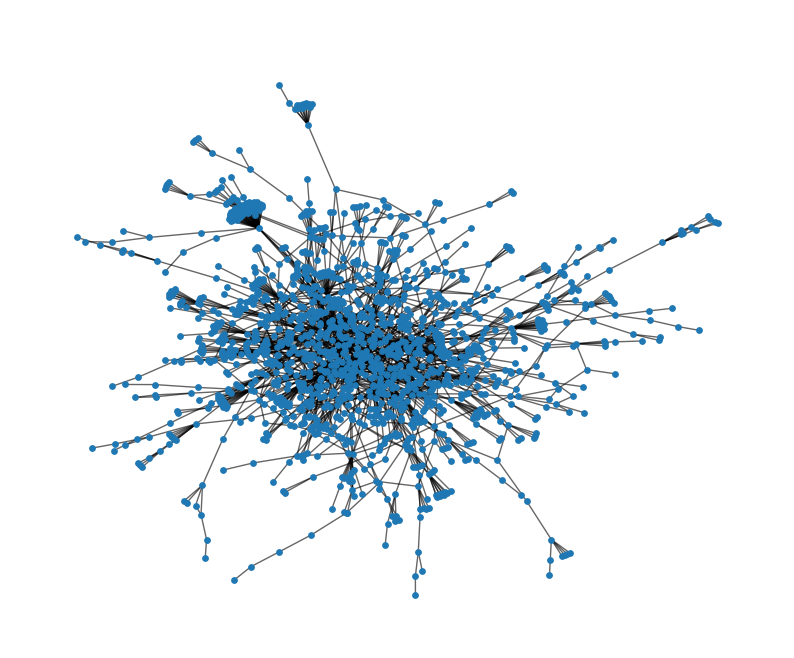

In [ ]:
plot_graph(G_temp)

Did we get it right, or did we lose some functionality of the biological network? It's unclear. However, we certainly aimed to improve connectivity and efficiency. While the strategies successfully restore global efficiency and structural integrity, the biological relevance of the newly introduced connections remains uncertain.